# Test Time Adaptation through externally guided Region Proposal Augmentation

 <br/>**Authors:** Giacomo Tomezzoli (241091) &  Davide Vandelli (240207)
 <br/>**Contact:** `{giacomo.tomezzoli, davide.vandelli} [at] studenti.unitn.it`
 <br/>**Github:** [https://github.com/gzemo/tta-deep-learning.git](https://github.com/gzemo/tta-deep-learning.git)
 
## Abstract
Test Time Adaptation (TTA) is considered to be an out-of-the-box self-supervised procedure expected to enhance model predictive capability by exploitable test set features via an online learning stage. With the purpose of addressing domain shift by increasing the confidence updating parameters
In order to tackle the domain shift problem a externally guided Region Proposal module had been developed to autonomously provide a guided search over portion of the given image of interest at test time to further exclude irrelevant areas that may hindered the object classification. (go on)


---

#### Table of contents:
1. [Hypothesis and motivation](#Hypothesis-and-motivation)
2. [Project architecture](#Project-architecture)
    1. [Pipeline description](#Pipeline-description)
    2. [Region Proposal search by Evolutionary Computation](#Region-Proposal-search-by-Evolutionary-Computation)
    3. [Region Proposal by grounding zero-shot object detection](#Region-Proposal-by-grounding-zero-shot-object-detection)
    4. [Addressing for small cropped regions](#Addressing-for-small-cropped-regions)
    5. [Augmentation](#Augmentation)
3. [Implementation](#Implementation)
    1. [Test set folder name conversion](#Test-set-folder-name-conversion)
    2. [Backbone loading](#Backbone-loading)
    3. [Marginal entropy loss](#Marginal-entropy-loss)
    4. [Entropy feature map](#Entropy-feature-map)
    5. [Frequency filtering](#Frequency-filtering)
    6. [CMA-ES implementation](#CMA-ES-implementation)
    7. [Load and test Super Resolution (SR) model](#Load-and-test-Super-Resolution-(SR)-model)
    8. [Testing augmentation](#Testing-augmentation)
    9. [Optimizer definition according to backbone](#Optimizer-definition-according-to-backbone)
    10. [Download and test Grounding DINO](#Download-and-test-Grounding-DINO)
    11. [S3 bucket implementation](#S3-bucket-implementation)
    12. [Region proposal TTA Implementation](#Region-proposal-TTA-Implementation)
    13. [Testing Grounding DINO](#Testing-Grounding-DINO)
6. [Results](#Results)
    1. [Baseline infrerence](#Baseline-inference)
    2. [Evolutionary RP results](#Evolutionary-RP-results)
    3. [Zero-shot object dectection results](#Zero-shot-object-detection-results)
    4. [Performance comparison](#Performance-comparison)
7. [Discussion](#Discussion)
8. [Conclusion](#Conclusion)
9. [References](#References)


---


## Hypothesis and motivation 

Domain shift might be heavily influenced by conditions in which target objects are not well centered and marginally covering a restricted area of the whole test image, or may be concealed by unrelated objects. Therefore, while directing evaluating the resulting class predictions at test time with either allowing for augmentation based adaptation by learning through confidence minimization or not, image classificators may still struggle to predict the corresponding class label mostly due to detection issues.
The present work provides an attempt that tackles the aforementioned hindrance by allowing to guide the extraction of cropped regions with the purpose of directly selecting areas that are supposed to be informative and to be more likely to contain the target object.<br/>
Two Region Proposal approaches had been implemented and tested over _Imagenet-A_ dataset leveraging:
- an augmentation search optimization by means of Evolutionary Computation and,
- a probalistically sampling from target identification results generated by prompt based zero-shot object detection model.



## Project architecture

### Pipeline description

![IMAGE HERE](https://github.com/gzemo/tta-deep-learning/pics/... "Project pipeline. Description here")

Each _Imagenet-A_ test image $\{x_i^{test}\}_{i=1}^{N}$ of dimension $\mathbb{R}^{C, H_i, W_i}$ is individually considered while performing the adaptation at test time. The complete workflow is described as follows:

1. Each image is converted in "RGB" and linearly interpolated to match pretrained image classificators models input dimension yielding $x_i^{test} \in \mathbb{R}^{3, H, W}$ for which $H = W = 224$.

2. a _Region Proposal_ module, that will be further described in details, takes $x_i^{test}$ in order to generate a mini-batch of informed portions of the original image size re-interpolated to match the model input dimension yielding $\mathbf{x} \in \mathbb{R}^{B, 3, 224, 224}$.

3. The current batch $\mathbf{x}$ is processed by augmenting each tensor according to a uniformly sampled $\mathit{a} = \{a_1, .., a_B\}$ functions from $\mathit{U(A_{AutoAugm})}$ with replacement yielding $\mathbf{\tilde{x}} = \mathit{a}(\mathbf{x})$.

4. The augmented batch is then used as input to a pre-trained image classificator $f$ with $\theta$ parameters and output dimension $N_c$, to firstly generate the marginal probability distribution $p_{\theta}(y|\mathbf{\tilde{x}}) = f_\theta (\mathbf{\tilde{x}})$ of dimension $(\mathbb{R}^{B, N_{c}})$: the average distribution is estimated by averaging over batch images' probability distributions $\bar{p_{\theta}}(y|\mathbf{\tilde{x}}) \in \mathbb{R}^{1, N_{c}}$.

5. The Entropy loss function $\mathbf{H}(·)$ is estimated over the averaged marginal probability distribution:
\begin{equation}
l(\theta; \mathbf{\tilde{x}}) = \mathbf{H}(\bar{p_{\theta}}(·|\mathbf{\tilde{x}})) = - \sum_{y \in N_c} \bar{p_{\theta}}(y|\mathbf{\tilde{x}}) \;log\bar{p_{\theta}}(y|\mathbf{\tilde{x}})
\end{equation}

6. Model's parameters are updated by an updating rule $G_f$ and a learning rate $\alpha$ yielding $\theta' \leftarrow G_f(\theta, \alpha, l(\theta; \mathbf{\tilde{x}}) )$

7. The final inference is computed by performing $f_{\theta'}(\mathbf{\tilde{x}})$ using the currently updated model parameters and averaging the resulting marginal probability distribution resulted from the same augmented batch.
\begin{equation}
\hat{y} = argmax_y \; \bar{p_{\theta'}}(y|\mathbf{\tilde{x}})
\end{equation}


### Region Proposal search by Evolutionary Computation 

**Overview.** *Evolutionary Algorithms* (EA) are general purpose stochastic optimization techniques that iteratively instantiate candidate solutions over a pre-defined search space with the goal of performing an informed search heading towards the global optimum of a fitness function. EA solutions are to be considered as instances that _evolved_ throughout _generations_ by means of biologically-derived principles like selection of the most fit solutions and recombination between instances' features allowing to trade between _exploitation_  and _exploration_ of previously seen features and to generate new instances that will further investigate the goodness of unseen search space solutions. An instance is therefore modelled by a _a)_ *genotypic* representation which is usually describe by a numerical/binary vector that has to be managed in order to combine and generate new solutions with new and previously seen features and a _b)_ *phenotypic* representation, the corresponding perceivable representation of the genotype ([Bartz-Beielstein et al., 2014](https://wires.onlinelibrary.wiley.com/doi/full/10.1002/widm.1124)).

**Modelling the optimization problem.** We exclusively considered the crop function while performing the optimization procedure and we modelled the continuous search space over $d=4$ variables, which are namely the resulting bounding box parameters obtained while applying cropping ($x_0, y_0, w, h$) i.e. upper-left corner coordinates, width and height respectively. Therefore the genotypic representation of each solution is represented by a 4-dimensional vector representing the set of bounding box parameters and the corresponding phenotype is the resulting cropped portion of the test image. Each evolutionary instance (a candidate bounding box according to which the test image can be cropped) needs to be paired to its corresponding fitness in order to rank the pool of solutions from the most fit to the least one. Each optimization run is therefore *image-dependent* in the sense that each test data presents a peculiar search space _per-se_.<br/>
Users are left with the choice to tune how many generations has the population to evolve: given that there is no way to analytically know the fitness function to be optimized in advance, convergence of solutions is likely to occur in either global optimum or local optima that may generate candidate regions that are not even centered over a target object. Since we are interest to have a _guided_ search that explore the test image rather than an _coverged_ search (made by optimized solutions) we have set $G=5$ to evolve for few generation.

**The algorithm choice.** The EA adopted to iteratively evolve solutions over generation is *Covariance Matrix Adaptation - Evolutionary Strategy* (CMA-ES) which is a continuous optimization paradigm that seeks to minimize an objective function $f: \mathbb{R}^d \rightarrow \mathbb{R}$ over $d$ dimensions.<br/>
Initial $\mu$ solutions from the 0-th generation are randomly sampled from a multi-variate Normal distribution $\mathit{N}(m, \sigma^2 C)$ for which $m \in \mathbb{R}^d$, $\sigma \in \mathbb{R}$ and $C \in \mathbb{R}^{d,d}$ are the vector of means over each dimension, the stepsize and the covariance matrix respectively.<br/>
At each step ($g=1, ..., G$) $\{x_j^{[g]}\}_{j=1}^{\lambda}$ solutions (in our case $\mu = \lambda = B$) are sampled from $\mathit{N}(m^{[g]}, \sigma^{2 [g]} C^{[g]})$ and sorted in ascending order according to their fitness function. At each ranked solution a fitness-proportioned $w_j$ factor is associated in order to be used while updating the $p_{\sigma}^{[g+1]}$, $p_{c}^{[g+1]}$ evolution paths that will further used in the distribution parameter estimation. Each new generation is therefore sampled towards a progressively improved distribution guided by the current offspring best performing solutions, allowing for an aoutonomously tuned tradeoff between exploration of the search space and exploitation of previously seen features ([Nomura & Shibata, 2024](https://arxiv.org/abs/2402.01373)).

Three _approaches_ had been designed to tackle the optimization procedure according to different evaluation (fitness) functions: 

1. **Model based:** for each individual test image and for each $j-th$ candidate cropped region at generation $g$, $\{x_j^{[g]}\}_{j=1}^B$ is rescaled to the model input dimension and evaluated by the image classificator $f_\theta$ yielding a probability distribution on which the prediction confidence across classes is estimated by means of the entropy function.
\begin{equation}
fitness(x_j^{[g]}) = \mathbf{H}(p_\theta(·|x_j^{[g]})) = \mathbf{H}(f_\theta(x_j^{[g]}))
\end{equation} entropy function. 
The rationale relies on the assumption according to which the lower the entropy, the more likely to have a cropped test image portion that focuses over a single target object. On the contrary, candidate solutions that present increased entropy values (hence less confidence over the area under examination) are less expected to reproduce and generate new offsprings and are more likely to go extinct. It is worth notice that the convergence procedure requires to evaluate the current $g-th$ batch of candidate regions for the amount of generation, thus performing $f_{\theta}(\mathbf{x}^{[g]}) : g = 1, ..., G $ unfortunately resulting in a higly expensive run considering that the current evolutionary procedure needs to iteratively wait for the previous generation to be completed in order to proceed.  <br/><br/>

2. **Entropy map based:** each test image is firstly converted from RGB to grayscale in order to collapse channels into a single dimension. A customly built 2D Entropy pooling layer has been developed as a function that perform pooling over a given grayscaled test image by performing the entropy function over a squared $k\times k$ kernel: the higher the kernel size $k$, the wider the receptive-field on which entropy needs to be computed and therefore the area of a coarser-grained effect will be gathered throughout the whole image.<br/>
It has been implemented in order to estimate a spatial measure of variability by striding over the preprocessed grayscale input in order to generate a same-padding (by performing `striding=1` and pre-padding the external image boundaries with closest image pixel value to avoid entropy drops in the edge-most regions) feature map resulting in a $\mathbb{R}^{1, H, W}$ tensor of the same test image size: the lower the resulting entropy value estimated in a specific image coordinate, the higher the heterogeneity over the sourrounding region on that coordinate by a given $k$. This effect is ideally expected to provide a "low-level", computationally inexpensive feature representation that may be informative while proceeding with the cropping proposal search.<br/>
Each $x_j^{[g]} \in \mathbb{R}^{1, h, w} : h \leq H \;, w \leq W$ candidate solution is selected accordingly to a fitness function that evaluates the average amount of entropy each cropped bounding box has extracted by also weighting according to the inverse of the current bounding box area: the smaller the size of the image captured, the higher the "penalty" and thus the lower the chance of that solution to survive selection and to further contribute to the optimization procedure. The fitness function is defined by the following equation:
\begin{equation}
fitness(x_j^{[g]}) =  avg(\mathbf{H}(x_j^{[g]})) + \alpha \times \left( \frac{1}{(h/H) \times (w/W) + \epsilon} \right)
\end{equation}
where $avg(\mathbf{H}(x_j^{[g]}))$ is the averaged entropy value extracted from the flattened values from the candidate cropped region $j-th$ at generation $g$, $(h,w)$ are the current region proposal dimension and $\alpha=0.001, \epsilon=10^{-5}$.
<br/><br/>

3. **Frequency filtering entropy map based:** it follows the same rationale as in the "Plain" version with the exception that the initial test image is processed by filtering high-frequency components to better enhace portions that may be associated to fine-grained details and objects' boundaries.
A binary high-frequency enhancing mask can be formalised by the high-pass filtering function ${M}^{S}_h$, according to a given filter size $S$, is formally defined as:
\begin{equation}
% \small
\begin{split}
\!{M}_h^{\!S}\!(x_i^{test})\! =\! {F}^{-\!1}(m\! \odot\! {F}(x_i^{test})), \text{where} \
m_{i,j}\!=\!
\left\{\begin{array}{l}
0, \  \text{if} \  \min(|i\!-\!\frac{H}{2}|,|j\!-\!\frac{W}{2}|) \!\leqslant\! \frac{\min(H,W)\!-\!S}{2} \\
1, \ \text{otherwise}
\end{array}\!,
\right.
\end{split}
\end{equation}
Where $m \in \{0, 1\}H \times W$, ${F}$ and ${F}^{-\!1}$ refer to the direct and inverse Fourier Transformation respectively. $S$ has been set to be equal to the model input size ($S=W=H=224$) allowing to fully extract high-frequency components from each test image. <br/>
Finally, from the resulting single channel (grayscaled) preprocessed test data the previously entropy map based optimization procedure is computed ([Bai et al., 2022](https://arxiv.org/abs/2204.00993)).<br/>


### Region Proposal by grounding zero-shot object detection 

Another promising attempt that is expected to improve TTA augmentation procedure while searching for informative portions of the test image would be to directly adapt a pre-trained object detector to find and isolate target objects. However, considering that the current interest relies on the need for seamlessly attach an independent and out-of-the-box adaptation module at test time, a specifically supervised-trained object detector over the _closed-set_ of test data classes should be required which would be cost-proibitive and unfeasible. With this in mind, an _open-set_ object detector model is expected be able to fullfil the detection task withouth undergoing a training procedure by generalizing predictions over newly unseen classes with a certain confidence level. In light of these premises, **Grounding-DINO** a zero-shot object detection model with grounded pre-training had been gathered and implemented to detect arbitray objects in a prompt-based fashion ([Liu et al., 2023](https://arxiv.org/abs/2303.05499)).

Its architecture is based over a dual encoder, single decoder model composed by an _a) image encoder_ and a _b) text encoder_ entitled to map images and text in a lower dimensional space, a _c) feature enhancer_ to merge image and text embeddings by leveraging cross-modality attention layers, a _d) language-guided query selection module_ to extract image features that are more relevant with respect to the provided text input in order to generate cross-modality queries and a _e) cross-modality decoder_ that will merge features-enhanced image and text embeddings to jointly perform image and text cross-attention over the currently gathered cross-modality queries.

Grounding-DINO requires an `{image, text}` pair to perform bounding box regression over an image by considering a text prompt of required targets to be detected. A fixed prompt had been chosen with the purpose of semantically including as much _Imagenet_ labels as possible: given the large amount of classes, general terms such as "animals", "tools", "objects", "birds" were included in order to be semantically inclusive and to let the model generate candidate cropped region in a permissive manner. Furthermore, we relied over the `box_thr` and `text_thr` thresholds hyperparameters enabling the bounding box inference to be adressed by allowing low confidence detected target objects to be retained.

Considering that the final amount of region proposal can not be known in advanced, a confidence based approach has been implemented to populate the final $\mathbf{x}$ batch of cropped region by sampling with replacement according to the resulting DINO bounding boxes' probability. In other terms, the higher the zero-shot detection confidence to track a given target object, the higher the probability to include that region in the final region proposal batch.

As in previous region proposal approaches each test image is individually considered while performing TTA: _further improvements_ can be developed in order to exploit the newly `Transformers` library [implementation](https://github.com/NielsRogge/Transformers-Tutorials/tree/master/Grounding%20DINO) that allows to perform zero-shot object detection by mini-batches.
 

### Addressing for small cropped regions

An intrinsic hindrance may be observed while performing region proposal: the resulting batch that will be processed to perform one-epoch training and inference may include very small regions that are expected to lose quality while resizing to match the model input dimension. A Super Resolution (SR) model based over Swin transformers ([Liang et al., 2021](https://arxiv.org/abs/2108.10257)) had been adopted to super-resolve region proposals that whose area was found to be less than a given fraction (0.33) of the input model image size.
An optional SR model can therefore been applied in order to super-resolve the resulting batch of cropped region after the evolutionary optimization or the zero-shot object detection had been completed $\mathbf{x}_{SR} = f_{SR}(\mathbf{x}$).

###  Augmentation

The mini-batch generated by any of the Region proposal approaches had been augmented by means of Auto-augmentation
([Cubuk et al., 2018](https://arxiv.org/abs/1805.09501)), a Reinforcement Learning-based approach that had been trained to find agmentation strategies over the space of possible augmentation by learning an optimal policy over Imagenet data.
Specifically a set of augmentation functions $\mathit{a} = \{a_1, ..., a_B\}$ sampled from $\mathit{U(A_{AutoAugm})}$ had been collected and used to process the resulting $\mathbf{x}$ region proposals generating $\tilde{\mathbf{x}} = \mathit{a}(\mathbf{x}) \in \mathbb{R}^{B, C, H, W}$.

---

## Implementation

In [1]:
! pip install timm cmaes tqdm einops kornia supervision seaborn -q

In [2]:
%matplotlib inline

import os
import csv
import copy
import time

import itertools
import tarfile
import numpy as np
from PIL import Image
from cmaes import CMA
from tqdm import tqdm
from io import BytesIO

import timm
from timm.models import create_model

import torch
import torchvision
import torchvision.models as models

import torchvision.transforms.v2 as v2
from torch.nn.modules.utils import _pair, _quadruple
from torch.distributions import Categorical
import torchvision.transforms.functional as ttf

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from scipy.stats import entropy
from matplotlib import pyplot as plt

import pandas as pd
import boto3 # aws s3
from pathlib import Path
import gdown

# defining amount of Classes
NCLASSES = 1000

# defining DEVICE
DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"

print(DEVICE)

/opt/conda/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https:/

cuda:0


### Test set folder name conversion

The present chunk to address the discrepancies between Imagenet-1k (training set) class label names and Imagenet-A (test set) folder name conversion.

File description: `imagenet1k_classes.txt` (for class number to label conversion) and `folder2label_correct.txt` (that conteins Imagnenet-A class labels that will be used to match those from the original imagenet-1k true labels).

Purpose: to generate dictionary-like structures that maps Imagenet-1k class numbers to their corresponding label in order to have directly access to them at inference time. Maps are described as follows:
- `LABELS`: converts class number to original Imagenet true class label.
- `FOLDERS`: maps folder name from Imagenet-A to Imagenet-A true label name (which is different from Imagenet-1k)
- `COMMON`: maps Imagenet-1k folder names to Imagenet-A.

In [3]:
LABELS, FOLDERS, COMMON = dict(), dict(), dict()

# preparing Imagenet-A_1k class number to label map
# {nclass : label_origin}
with open("imagenet1k_classes.txt", "r") as f:
    for i, line in enumerate(f.readlines()):
        if i == 0: continue
        items = line.strip().split("|")
        LABELS[int(items[1].strip())] = items[2].strip().lower()

# preparing testfolder class to name
# {foldername : label_folder}
with open("folder2label_correct.txt", "r") as f:
    for line in f.readlines():
        line = line.strip().split(" ")
        foldername,  label = line[0], " ".join(line[2].split("_")).lower()
        FOLDERS[foldername] = label

# preparing folder labels to real Imagenet-A_1k labels map
# {label_origin : label_folder}
for k1 in FOLDERS.keys():
    query = FOLDERS[k1]
    for k2 in LABELS.keys():
        name, name_list = LABELS[k2], LABELS[k2].split(", ")
        for item in name_list:
            if query == item:
                COMMON[name] = query
                break
            break

### Backbone loading

The following chunk initializes the `backbone_loading` function that returns the model (`torch.nn.Module`) object according to a given `modelname` backbone function of interest. Torch allows to load and run a pretrained model by merging:
1. an `torch.nn.Module` object (the modelarchitecture).
2. the corresponding `.pth` file (a set of corresponding weights).

The 2 backbone models (namely,`ResNet50` and `RVT`) utilized by the original MEMO implementation had been leveraged by collecting the checkpoint files as in the official [repository](https://github.com/zhangmarvin/memo.git) (Zhang et al., 2022).


In [4]:
# clone MEMO repository.
if not os.path.exists("memo"):
    ! git clone https://github.com/zhangmarvin/memo.git memo -q
    ! mv memo/imagenet-exps memo/imagenet_exps

os.environ["TOKENIZERS_PARALLELISM"] = "false"   # ? Ho aggiunto questa linea per disabilitare questo errore (vedi sotto) durante la "baseline evaluation"
# huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
# To disable this warning, you can either:
# - Avoid using tokenizers before the fork if possible
# - Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)

from memo.imagenet_exps.utils.third_party import *

def backbone_loading(modelname):
    """
    Pretrained visual encoder backbone loading with state dictionary.
    Returns:
        model (torch.nn.Module)
        state (torch.nn.Module.state_dict) pretrained weights
    """

    # Resnet50 used as in MEMO references
    if modelname == "resnet":
        state_dict = dict()
        state_dict_raw = torch.load("memo/imagenet_exps/results/imagenet_rn50/ckpt.pth", map_location=torch.device(DEVICE))["state_dict"]

        # adapt state_dict to be used properly removing "module." from each layers key
        state_dict = {".".join(k.split(".")[1:]) : state_dict_raw[k] for k in state_dict_raw.keys()}

        model = models.resnet50()
        model.load_state_dict(state_dict)

    # Not sure to delete it or not!
    # Testing a ViT architecture trained over 21k (fine-tuned on 1k)
    elif modelname == "vit":
        model = timm.create_model("vit_base_patch16_224.augreg2_in21k_ft_in1k", pretrained=True)

    # RVT model as in MEMO
    elif modelname == "rvt":
        if not os.path.exists("rvt_small.pth"):

            # Params: model id from the MEMO official repository (RVT*-small) (add link)
            model_id = "1g40huqDVthjS2H5sQV3ppcfcWEzn9ekv"

            # Download weights
            os.system(f"! gdown {model_id} -O rvt_small.pth")

        # Load model struct: from memo
        model = rvt_small_plus(pretrained = True)
        state_dict = torch.load("rvt_small.pth", map_location=torch.device(DEVICE))
        model.load_state_dict(state_dict["model"])

    else:
        raise Exception("Choose a valid backbone model (resnet, resnet101, vit, rvt)")

    print(f"Loading backbone ({modelname}): Done.")
    return model.to(DEVICE)

In [5]:
# test usage
model = backbone_loading("resnet")

Loading backbone (resnet): Done.


### Marginal entropy loss

In order to perform an "online" learning stage an entropy function defining the amount of entropy estimated over the marginal probability distribution obtain from the final inference phase after one epoch training is initialized.


In [6]:
# define here Entropy loss:
class EntropyLoss(torch.nn.Module):

    def __init__(self):
        super(EntropyLoss, self).__init__()

    # custom built:
    def forward(self, avg_probs):
        return (-1)*torch.sum(torch.multiply(avg_probs, torch.log(avg_probs)))

### Entropy feature map 

In this section the Entropy map will be addressed by implementing a custom pooling layer that will be used in order to preprocess the test image to further optimize the evolutionary cropping search procedure. The `EntropyPool2d` class is exploiting the `torch.nn.Module` inheritance and can be executed via the `forward` method. Basically, this class addresses the image unfolding submatrices and maps the entropy function to each of them in order to fold back each submatrix to rebuild the original image structure. A torch implementation had been used to exploit GPU computing.

The other "cpu" based implementation will be eventually adopted while dealing with certain uncommon test image padding that will break the GPU based implementation.

In [7]:
# Efficiency entropy pooling map implementation via torch Module
class EntropyPool2d(torch.nn.Module):

    def __init__(self, kernel_size=3, stride=1, padding=0):
        super(EntropyPool2d, self).__init__()
        self.k = _pair(kernel_size)
        self.stride = _pair(stride)
        self.padding = _quadruple(padding)

    def _entropy(self, x):
        norm_x = x / x.sum()
        return Categorical(probs = norm_x).entropy()

    def forward(self, x):
        x = x.to(DEVICE)
        if len(x.shape) == 2:
            h,w = x.shape[0], x.shape[1]
        elif len(x.shape) == 3:
            h,w = x.shape[1], x.shape[2]
        x = x.reshape(1, 1, h,w)
        x = ttf.pad(x, tuple([(self.k[0]-1)//2]*4), padding_mode='edge')
        x = x.unfold(2, self.k[0], self.stride[0]).unfold(3, self.k[1], self.stride[1])
        x = x.contiguous().view(x.size()[:4] + (-1,))
        pool = self._entropy(x).squeeze(0)
        return pool.to("cpu")

# Functional version implementation
def e_pooling(img, kernel_size=3, stride=1, padding=0):
    """ Functional version of EntropyPool2d class
    """
    ep = EntropyPool2d(kernel_size, stride, padding).to(DEVICE)
    pool = ep(img)
    return pool.to("cpu")


# General purpose pooling function (with stride = 1 and "same" padding)
# allowing to perform any array-based function over unfolded sub-matrices.
# CPU based pooling operator is slower but more robust (can deal with certain
# image patterns (with blank padding))
def entropy_pooling(img, k=3, fun=entropy):
    """
    Perform same padding entropy pooling by convoluting a kernel of size k
    (and stride=1) over the imput image
    Args:
        img: (Pil.Image) image in grayscale
        k: (int) kernel size
        fun: function to apply (default: scipy.stats.entropy)
    Return torch.Tensor
    """
    assert k % 2 != 0, "Kernel size must be an even number."

    img = img.to("cpu")

    # tensor conversion (!!! remove it !!!)
    img = ttf.to_tensor(img) if not isinstance(img, torch.Tensor) else img
    h, w = img.shape[1:]

    # adding the channel dimension (bachsize, nchannel, H, W)
    img = img.reshape(1, 1, h, w)

    # padding by adding edge values all over the image boundaries
    img = ttf.pad(img, tuple([(k-1)//2]*4), padding_mode='edge')

    # unfolding
    folds = img.unfold(2, k, 1).unfold(3, k ,1).transpose(1,3).reshape(-1, 1, k, k)

    # Entropy pooling: applying the input function to each image sub-fold
    e_pooling = torch.tensor(list(map(fun, [folds[i, 0, :, :].flatten() for i in range(folds.shape[0])])))

    # folding back
    pooled = torch.reshape(e_pooling, (h,w)).transpose(-1,0).unsqueeze(0)

    return pooled

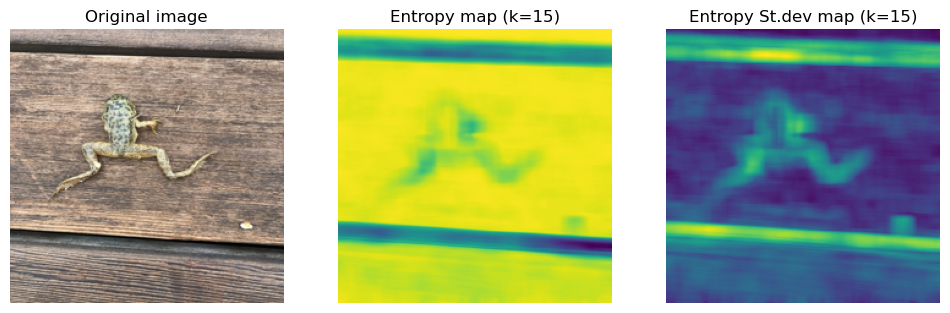

In [8]:
### EntropyPooling testing along with std.dev map given a kernel_size
### The higher the kernel_size the more "blurred" the resulting feature map.
imagename = "frog.jpg"
orig = Image.open(imagename).convert("RGB").resize((224,224))
img  = ttf.to_tensor(orig.convert("L"))

k = 15

# pooling module
#ep = EntropyPool2d(kernel_size = k).to(DEVICE)
#emap = ep(img)

emap = e_pooling(img, k)

# std map
stdmap = entropy_pooling(img, k = k, fun = torch.std)

# plotting
fig, axs = plt.subplots(1,3,figsize=(12,8))

axs[0].imshow(orig)
axs[0].set_title("Original image")
axs[0].axis("off")
axs[1].imshow(emap[0,:,:])
axs[1].set_title(f"Entropy map (k={k})")
axs[1].axis("off")
axs[2].imshow(stdmap[0,:,:])
axs[2].set_title(f"Entropy St.dev map (k={k})")
axs[2].axis("off")
plt.show()

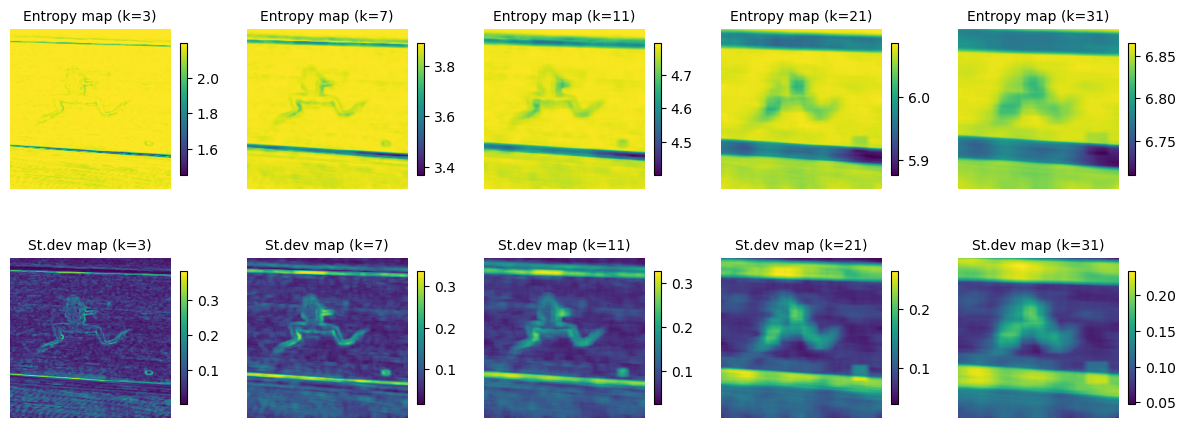

In [9]:
# precompute the entropy map for a grid of kernel sizes with the purpose
# of displaying it along with std.dev map
tosave = dict()
ks = [3, 7, 11, 21, 31]
for k in ks:
    emap = e_pooling(img, k)
    s = entropy_pooling(img, k=k, fun=torch.std)
    tosave[k] = (emap,s)

# plot
fig, axs = plt.subplots(2, 5, figsize=(12,5))
for i, ax in enumerate(axs.flatten()):
    if i < 5:
        mat = ax.imshow(tosave[ks[i]][0][0,:,:])
        ax.set_title(f"Entropy map (k={ks[i]})", fontsize=10)

    else:
        mat = ax.imshow(tosave[ks[i-5]][1][0,:,:])
        ax.set_title(f"St.dev map (k={ks[i-5]})", fontsize=10)

    ax.axis("off")
    cbar = fig.colorbar(mat, ax = ax, shrink=0.55)

plt.tight_layout()
plt.show()

It can be noticed that entropy and St.dev maps are specularly depicting the pixel value variability, meaning that the lower the entropy value estimated over a given pixel coordinate and by a pre-defined kernel size, the higher the standard deviation of the distribution of the neighbouring values. This low-level feature map may come useful while performing evolutionary guided search, allowing the candidate region proposal to select different image portion and evaluate them in order to minimize the averaged entropy of the cropped feature map.

### Frequency filtering
This filtering implementation aims to filter the original (gray-scale converted) test image by retaining only those informations belonging to high frequency components that are supposed to better represent image boundaries and fine grained details. The purpose is to extract a feature map that enhance information usually associated to object boundaries and shapes.

The resulting high-pass filtered grayscale test image is then process by the EntropyPooling layer according to some kernel sizes in order to extract the feature map that will be further used to optimize the region proposal search.

In [10]:
def freq_mask(h,w,s, freq="low"):
    """
    Compute mask estimation according to either "low" or "high"
    frequency pass.
    Args:
        h,w: (int) hight and width image size
        s: (int) filter threshold
        freq: (str) "low" or "high" filter
    Return:
        torch.Tensor binary mask
    """
    xc = np.where(abs(np.arange(0, w)-(w/2)) <= s/2, 1, 0)  if freq=="low" \
        else  np.where(abs(np.arange(0, w)-(w/2)) <= (min(h,w)-s)/2, 0, 1)
    yc = np.where(abs(np.arange(0, h)-(h/2)) <= s/2, 1, 0)  if freq=="low" \
        else  np.where(abs(np.arange(0, h)-(h/2)) <= (min(h,w)-s)/2, 0, 1)
    return yc.reshape((yc.shape[0],1)).dot(xc.reshape((1,xc.shape[0])))

def freq_filter(img, h,w,s, freq="low"):
    """
    Return the preprocessed frequency map image according to either
    "low" or "high" frequency pass.
    Args:
        img: (torch.tensor) input image
        h,w: (int) hight and width image size
        s: (int) filter threshold
        freq: (str) "low" or "high" filter
    Return:
        torch.Tensor
    """
    return torch.tensor(abs(np.fft.ifft2(np.multiply(freq_mask(h,w,s,freq),
                                                    np.fft.fftshift(np.fft.fft2(img))
                                                    )))).unsqueeze(0)

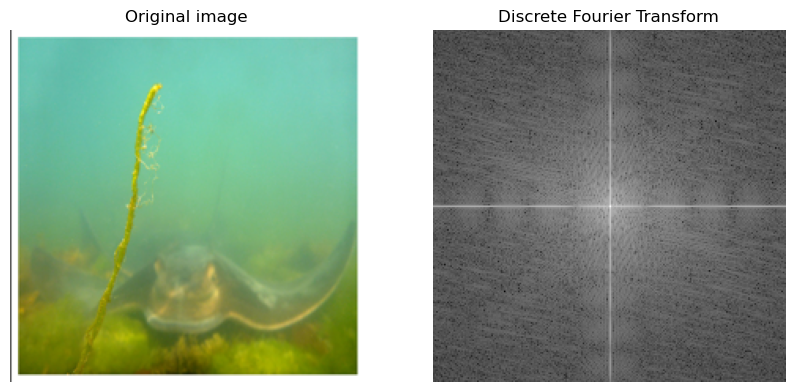

In [11]:
### testing the effect over an image
imgfilename = "imageneta.png"
h,w = (224,224)
orig = Image.open(imgfilename).convert("RGB").resize((h,w))
img  = Image.open(imgfilename).convert("L").resize((h,w))
ftransformed = np.fft.fftshift(np.fft.fft2(img))
inv_ftrasformed = np.fft.ifft2(ftransformed)

# plotting
fig, axs = plt.subplots(1,2,figsize=(10,7))
axs[0].imshow(orig)
axs[0].set_title("Original image")
axs[0].axis("off")
axs[1].imshow(np.log(abs(ftransformed)), cmap='gray')
axs[1].set_title("Discrete Fourier Transform")
axs[1].axis("off")
plt.show()

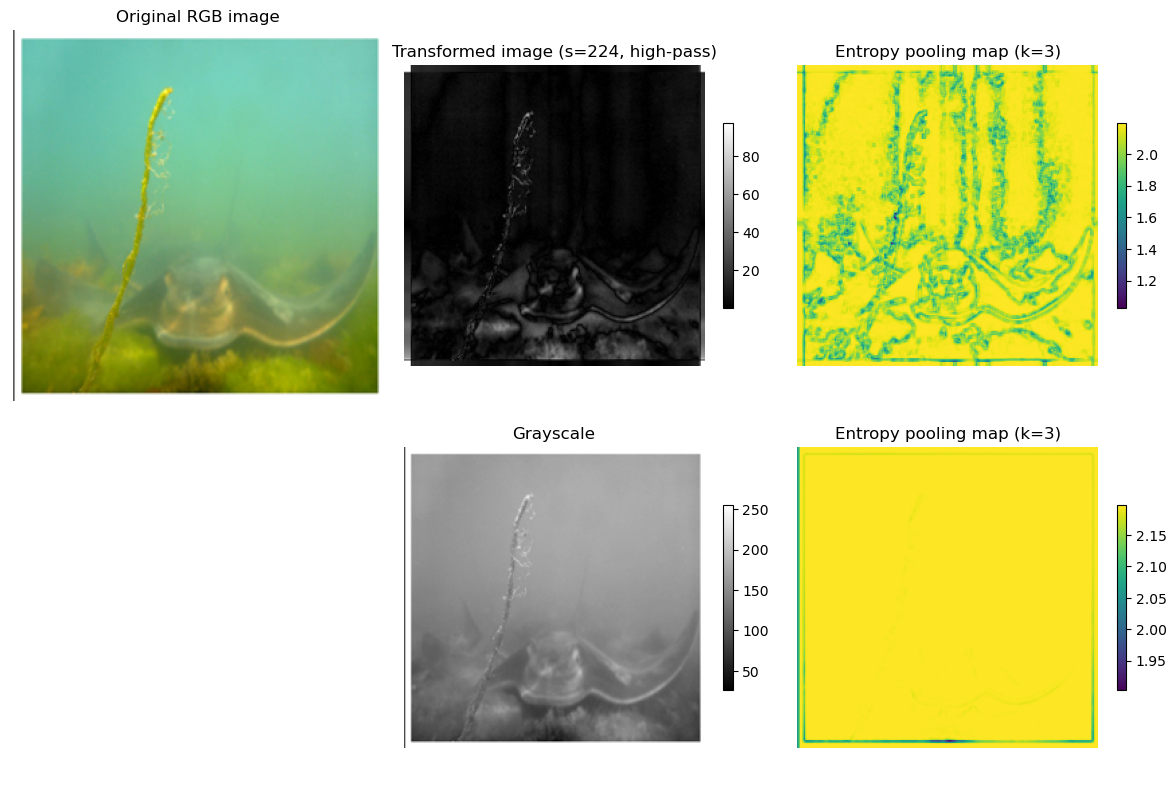

In [12]:
# Hyperparameters definition
factor = 1            # how much s needs to be reweighted (0=none,1=full)
s      = h * factor   # freq filter size
k      = 3            # entropy pooling kernel size
freq   = "high"       # "low" or "high" pass filtering

freq_filt_img = freq_filter(img, h, w, s, freq)
ep = EntropyPool2d(kernel_size=k).to(DEVICE)

entropy_img_frmap = ep(freq_filt_img)

try:
    entropy_img_map   = ep(ttf.to_tensor(img))
except:
    entropy_img_map   = entropy_pooling(ttf.to_tensor(img), k=k)

fig, axs = plt.subplots(2 , 3, figsize=(12,8))
axs[0][0].imshow(orig)
axs[0][0].set_title("Original RGB image", fontsize=12)
axs[0][0].axis("off")

m1 = axs[0][1].imshow(freq_filt_img[0,:,:], cmap="gray")
axs[0][1].set_title(f"Transformed image (s={round(s)}, {freq}-pass)", fontsize=12)
axs[0][1].axis("off")
cbar = fig.colorbar(m1, ax = axs[0][1], shrink=0.5)

m2 = axs[0][2].imshow(entropy_img_frmap[0,:,:])
axs[0][2].set_title(f"Entropy pooling map (k={k})", fontsize=12)
axs[0][2].axis("off")
cbar = fig.colorbar(m2, ax = axs[0][2], shrink=0.5)

axs[1][0].axis("off")

m4 = axs[1][1].imshow(img, cmap="gray")
axs[1][1].set_title(f"Grayscale", fontsize=12)
axs[1][1].axis("off")
cbar = fig.colorbar(m4, ax = axs[1][1], shrink=0.5)

m5 = axs[1][2].imshow(entropy_img_map[0,:,:])
axs[1][2].set_title(f"Entropy pooling map (k={k})", fontsize=12)
axs[1][2].axis("off")
cbar = fig.colorbar(m5, ax = axs[1][2], shrink=0.5)

plt.tight_layout()
plt.show()

In this section the entropy pooling is estimated over the high-pass filtered (above) and the original grayscale image for a given kernel_size ($k=3$) resulting in different feature maps that will consequently yield different outcomes while performing the evolutionary search. One may expect then that the search process over those feature maps would converge over different regions, enabling to differently explore the space of cropping regions.

### CMA-ES implementation

The Evolutionary approach adopted as follows has been gathered from the Nomura & Shibata (2024) python library [implementation](https://github.com/CyberAgentAILab/cmaes?tab=readme-ov-file) (_see_ [Region proposal TTA Implementation](#Region-proposal-TTA-Implementation)) and it has been implemented in the `EvoTTA.evolve()` method. It can be initialise as follows:

```{python}
optimizer4d = CMA(mean = np.array([0.2, 0.2, 0.6, 0.6]),
                  sigma = 0.1,
                  bounds = np.array([(0,1), (0,1), (0,1), (0,1)]),
                  population_size = self.popSize,
                  seed = np.random.randint(0, 10**5),
                  lr_adapt = True)
```
by specifying the array of dimensions' means (`mean`) and stepsize (`sigma`), the initial distribution parameters from which solutions at $g=0$ will be sampled, the edge limits for each dimension (`bounds`) and whether to adaptively modify the model parameters upate (`lr_adapt`). Specifically, we are instantiating candidate cropped region by selecting the initial population of bounding boxes to be sampled by considering $\mathit{\mu} = \{\mu_{x_0} = 0.2, \mu_{y_0} = 0.2, \mu_{h} = 0.6, \mu_{w} = 0.6\}$ and $\sigma=0.1$ in order to sufficiently include large, centered, portions of the test image size.

`CMA` provides an "ask-and-tell" procedure, a general purpose optimization structure that requires the user interact with the evolutionary procedure by means of two methods:
- "ask" to retrieve solutions from the currently evolved population by a given generation $g$ (by `solution_i = CMA.ask()`)
- "tell" to submit the current pool of solutions along with the corresponding "values" (by `CMA.tell( (solution_i, value_i) )`)

At each time the CMA instance sees the solutions evaluation, a new generation is evolved yielding to update the population by sampling from the currently update model parameters.

#### Cropped region instance class
The current chunk initialise a `CropInstance` class which will deal with the size of candidate bounding boxes to adapt them by checking whether sizes respect certain arbitrary thresholds in order to have at least sufficiently large areas. This class will be further used in the `EvoTTA.evolve()` method while performing cropping instance augmentation search.

In [13]:
class CropInstance():
    """
    Normalised Crop instance (region proposal) over a given target image
    """
    def __init__(self, x: float, y: float, w: float, h: float, imgsize: tuple):
        assert 0 <= x < 1 and 0 <= y < 1, "Cropping point out of bound!"
        assert 0 <= w <= 1 and 0 <= h <= 1, "Bounding dimension out of bound!"
        self.x = x
        self.y = y
        self.w = w
        self.h = h
        self.imgsize = imgsize
        self.xlim, self.ylim = 1, 1
        self.w_min, self.h_min = 1/6, 1/6  # or even 1/5
        # check for min/max bounds
        self.w = self.w if self.w > self.w_min else self.w_min
        self.x = self.xlim - self.w if self.x + self.w > self.xlim else self.x
        self.h = self.h if self.h > self.h_min else self.h_min
        self.y = self.ylim - self.h if self.y + self.h > self.ylim else self.y
        # final check: consider to delete this section
        assert self.x + self.w <= self.xlim, "Cropping bounding box out of bound! (x axis)"
        assert self.y + self.h <= self.ylim, "Cropping bounding box out of bound! (y axis)"

        # integer conversion
        self.xint, self.yint, self.wint, self.hint = tuple(
            map(round,
                [self.x * self.imgsize[0],
                 self.y * self.imgsize[1],
                 self.w * self.imgsize[0],
                 self.h * self.imgsize[1]]
               )
        )
    def __str__(self):
        return  "-------------------- (x)    (y)    (w)    (h)\n"+ \
         f"fixed coords:  float: {self.x:.4f} {self.y:.4f} {self.w:.4f} {self.h:.4f}\n"+ \
         f"               int  : {(self.xint, self.yint, self.wint, self.hint)}"

### Load and test Super Resolution (SR) model
(In this section, the purpose of increasing the resolution of an image is to allow any backbone model to better focus on the details from a previously selected region. We loaded **SwinIR** a pre-trained image restoration model.

In [14]:
# clone repo
if not os.path.exists("SwinIR"):
    !git clone https://github.com/JingyunLiang/SwinIR.git

# load pretrained model params
if not os.path.exists("experiments"):
    !wget https://github.com/JingyunLiang/SwinIR/releases/download/v0.0/003_realSR_BSRGAN_DFO_s64w8_SwinIR-M_x4_GAN.pth -P experiments/pretrained_models

`sr_run` will run the image upscaling by either performing a fullpass or by splitting the original image into tiles and run the model on each tile.

In [15]:
from SwinIR.models.network_swinir import SwinIR as net

def get_sr_model():
    ''' Return SR model
    '''
    # state dict specification
    param_key_g = 'params_ema'
    model = net(upscale=4, in_chans=3, img_size=64, window_size=8,
                img_range=1., depths=[6, 6, 6, 6, 6, 6],
                embed_dim=180, num_heads=[6, 6, 6, 6, 6, 6],
                mlp_ratio=2, upsampler='nearest+conv', resi_connection='1conv')
    model = model.to(DEVICE)
    pretrained_model = torch.load("experiments/pretrained_models/003_realSR_BSRGAN_DFO_s64w8_SwinIR-M_x4_GAN.pth")
    model.load_state_dict(pretrained_model[param_key_g] if param_key_g in pretrained_model.keys() else pretrained_model, strict=True)
    return model


def sr_run(lr_image, model, sf, tile, overlap, verbose=True):
    ''' Adapted from https://github.com/JingyunLiang/SwinIR/blob/main/main_test_swinir.py
    Upscale image by Super Resolution according to a scale factor (sf).
    Args:
        lr_image: (PIL image) Low Resolution image to be upscaled
        model: (torch.nn.Module) super resolution model
        sf: (int) scale factor, (default: 4)
        tile: (int) tile size while splitting the SR run (default: 32, 64)
        overlap: (int) pixel overlap
    Return:
        sr_image (torch.Tensor) of dims: (1, c, h, w) Super Resolution image
    '''
    lr_image = ttf.to_tensor(lr_image).unsqueeze(0) if not type(lr_image)==torch.Tensor else lr_image

    print(f"    LR image size: {lr_image.shape}", end=" ") if verbose else None

    model.eval()

    b, c, h, w = lr_image.size()

    fullImagePass = True if min(h, w) <= tile else False

    # test the image without tiling (single full pass)
    if fullImagePass:
        print(" - full pass LR image") if verbose else None
        with torch.no_grad():
            sr_image = model(lr_image.to(DEVICE))

    # unfold and process the image tile by tile (multiple subset pass)
    else:
        if verbose:
            print(" - Unfolding LR image...")
        assert tile < min(h,w), "Tile must be less than imagesize (h,w) "

        # Collect tiles
        stride = tile - overlap
        h_ids = [i for i in range(0, h - tile, stride)]
        w_ids = [j for j in range(0, w - tile, stride)]
        h_ids.append(h - tile)
        w_ids.append(w - tile)
        h_idx_list = list(range(0, h - tile, stride)) + [h - tile]
        w_idx_list = list(range(0, w - tile, stride)) + [w - tile]

        # Init output of zeros
        E = torch.zeros(b, c, h * sf, w * sf).type_as(lr_image)
        W = torch.zeros_like(E)

        # Unfold and perform sr over patches
        for h_id in h_ids:
            for w_id in w_ids:
                in_patch = lr_image[..., h_id : h_id+tile, w_id : w_id+tile]

                with torch.no_grad():
                    out_patch = model(in_patch.to(DEVICE))

                out_patch = out_patch.to(DEVICE)
                out_patch_mask = torch.ones_like(out_patch)
                E[..., h_id*sf:(h_id+tile)*sf, w_id*sf:(w_id+tile)*sf].add_(out_patch)
                W[..., h_id*sf:(h_id+tile)*sf, w_id*sf:(w_id+tile)*sf].add_(out_patch_mask)
        sr_image = E.div_(W)

    return sr_image

In [16]:
# select image:
x = ttf.to_tensor(Image.open("frog.jpg").convert("RGB").resize((56,56))).unsqueeze(0)

x = x.to(DEVICE)
srmodel = get_sr_model()
sr = sr_run(x, srmodel, sf=4, tile=32, overlap=4)

#print("input:  ",x.shape)
#print("output: ",sr.shape)

/opt/conda/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /home/conda/feedstock_root/build_artifacts/pytorch-recipe_1698976205261/work/aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


    LR image size: torch.Size([1, 3, 56, 56])  - Unfolding LR image...


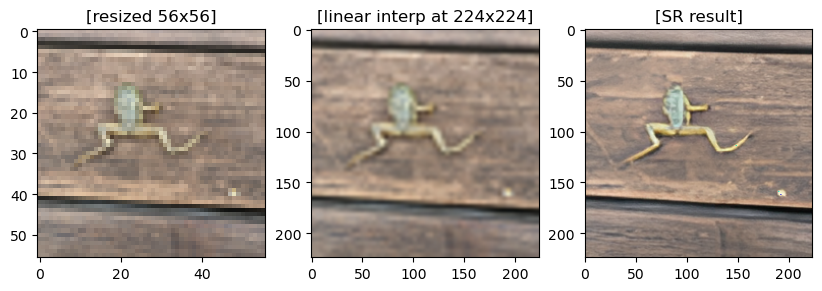

In [17]:

fig, axs = plt.subplots(1,3,figsize=(10,7))

axs[0].imshow(ttf.to_pil_image(x.squeeze(0)))
axs[0].set_title("[resized 56x56]")
axs[1].imshow(ttf.to_pil_image(x.squeeze(0)).resize((224,224)))
axs[1].set_title("[linear interp at 224x224]")
axs[2].imshow(ttf.to_pil_image(sr.squeeze(0)))
axs[2].set_title("[SR result]")

#kernel_size = 11
#ax[1,0].imshow(e_pooling(ttf.to_tensor(ttf.to_pil_image(x.squeeze(0)).convert("L")), kernel_size).squeeze(0))
#ax[1,1].imshow(e_pooling(ttf.to_tensor(ttf.to_pil_image(x.squeeze(0)).resize((224,224)).convert("L")), kernel_size).squeeze(0))
#ax[1,2].imshow(e_pooling(ttf.to_tensor(ttf.to_pil_image(sr.squeeze(0)).convert("L")), kernel_size).squeeze(0))

plt.show()

The present graph shows the resulting SR reconstruction result from an originally rescaled image along with its linear interpolation.

### Testing augmentation

Although the adopted augmentation strategy should have been _dataset-independent_ in order to be truly out-of-the-box, AutoAugmentation plus random horizontal flip has been considered to better address the augmentation phase in order to apply the best performing functions in light of the "episodic" learning phase. A brief presentation is shown as below.

In [18]:
def get_augmenter():
    '''
    Return AutoAugmenter policy pre-optimized over IMAGENET
    adding RandomHorizontalFlip (p = 0.5)
    '''
    return v2.Compose([
        v2.AutoAugment(v2.AutoAugmentPolicy.IMAGENET),
        v2.RandomHorizontalFlip(p=0.5),
        ]).to(DEVICE)

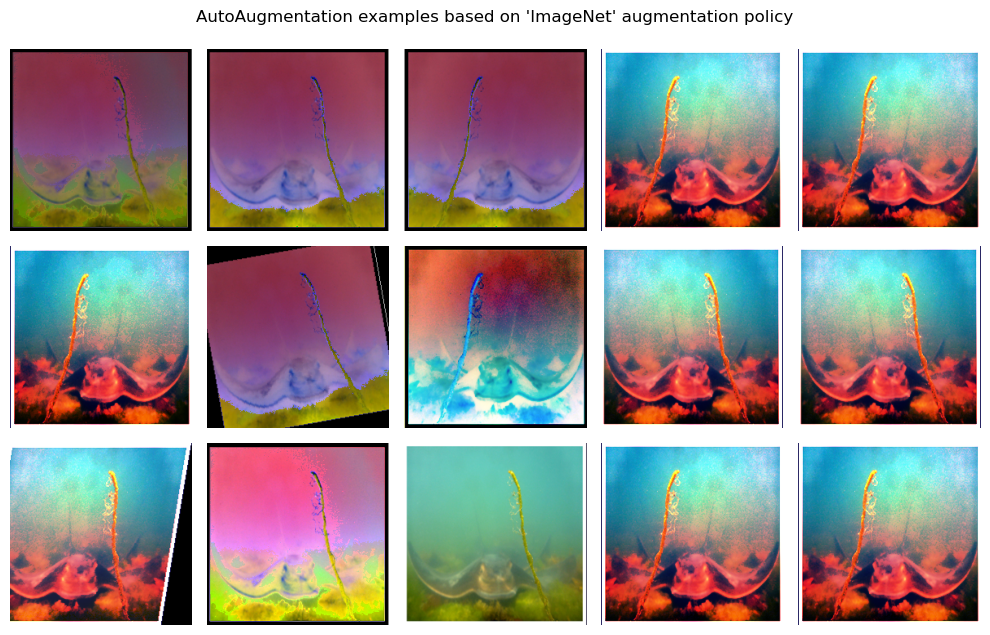

In [19]:
img = Image.open("imageneta.png").convert("RGB").resize((224,224))
augmenter = get_augmenter()

fig, axs = plt.subplots(3,5, figsize=(10,6.5))
for i, ax in enumerate(axs.flatten()):
    ax.imshow((augmenter(img)))
    ax.axis("off")

plt.suptitle("AutoAugmentation examples based on 'ImageNet' augmentation policy")
plt.tight_layout()
plt.show()

### Optimizer definition according to backbone

In this section, we test the contribution of CMA Evolutionary Strategy to the quality of the classification. The backbones used have been tested with their specific optimizer as in [Zhang et. al, (2022)](https://openreview.net/pdf?id=vn74m_tWu8O). Specifically:

- `ResNet50`: tested with Stocastic Gradient Descent (`lr = 0.00025`, `weight_decay = 0.0`)
- `RVT*-small`: tested with AdamW (`lr = 0.00001`, `weight_decay = 0.01`)


In [20]:
def get_optimizer(backbonename, model):
    """ Return the optimizer used as in reference paper according to backbone
    """
    if backbonename == "resnet":
        optimizer = torch.optim.SGD(model.parameters(), lr=0.00025, weight_decay=0.0)
    elif backbonename in ("resnet101", "vit", "rvt"):
        optimizer = torch.optim.AdamW(model.parameters(), lr=0.00001, weight_decay=0.01)
    print(f"Loading optimizer for backbone ({backbonename}), Done!")
    return optimizer

### Download and test Grounding DINO

For zero-shot learning: grounding DINO offers a prompt based zero-shot object detection able to detect objects belonging to previously unseen classes on which it had not been explicitly trained.


In [21]:
import requests
from transformers import AutoProcessor, GroundingDinoForObjectDetection

# loading DINO text and box processor and model
model_spec = "IDEA-Research/grounding-dino-tiny"
processor = AutoProcessor.from_pretrained(model_spec)
dinomodel = GroundingDinoForObjectDetection.from_pretrained(model_spec).to(DEVICE)

2024-07-10 07:08:04.335231: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-10 07:08:04.688000: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [22]:
from torchvision.ops import box_convert

def zeroshot_obj_detect(model, processor, image, promt, box_threshold, text_threshold):
    '''
    Return boxes and confidence
    '''
    device = next(model.parameters()).device 
    inputs = processor(images = image, text = promt, return_tensors = "pt")
    inputs = {key: value.to(device) for key, value in inputs.items()}   

    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)

    # convert outputs (bounding boxes and class logits) to COCO API
    #target_sizes = torch.tensor([image.size[::-1]]).to(device)  #qua ho aggiunto .to(device)
    #results = processor.image_processor.post_process_object_detection(
    #    outputs, threshold=0.35, target_sizes=target_sizes)[0]

    results = processor.post_process_grounded_object_detection(
        outputs,
        input_ids=inputs["input_ids"],
        box_threshold=box_threshold,
        text_threshold=text_threshold)[0]

    return results["boxes"], results["scores"]


/tmp/ipykernel_180/4243535967.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sorted_boxes = torch.cat([torch.tensor(box).unsqueeze(0) for _, box in tmp], 0)


21 41 160 113
23 43 156 110
26 45 150 105
21 41 160 113
26 45 150 105
20 40 161 116
0 1 224 182
32 51 138 88
23 43 156 110
23 43 156 110


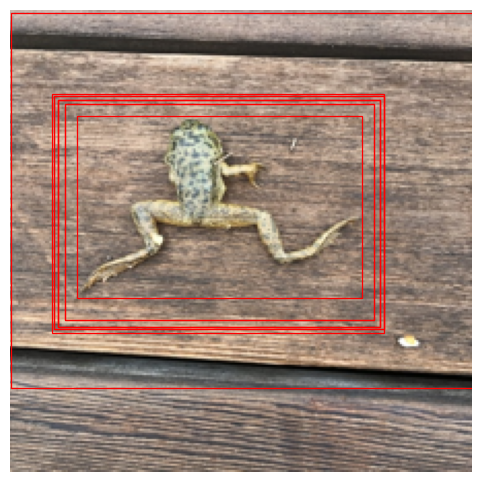

In [23]:
confidence = 1
n_batch = 10

W, H = (224,224)
img = Image.open("frog.jpg").convert("RGB").resize((W,H))
boxes, logits = zeroshot_obj_detect(dinomodel,
                                    processor,
                                    image=img,
                                    promt="animal . object . reptile .",
                                    box_threshold = 0.10,
                                    text_threshold = 0.10)

tmp = sorted([(logits[i].item(), boxes[i,:]) for i in range(logits.shape[0])],
                key = lambda x: x[0], reverse=True)

sorted_logits = torch.tensor([logit for logit, _ in tmp])
logits = sorted_logits[0:round(sorted_logits.shape[0] * confidence)]
prob_sampling = (logits/logits.sum()).numpy()

sorted_boxes = torch.cat([torch.tensor(box).unsqueeze(0) for _, box in tmp], 0)
sorted_boxes = sorted_boxes[0:logits.shape[0], :]
sample = np.random.choice(range(0, logits.shape[0]), size = n_batch,
                          replace=True, p=prob_sampling)
boxes = sorted_boxes[sample, :]

# convert from "xyxy" to "xywh" format (integer values)
xywh = box_convert(boxes = boxes.to("cpu") * torch.Tensor([W, H, W, H]),
            in_fmt="xyxy", out_fmt="xywh").numpy()

# generate cand bounding boxes
cbb  = [tuple(round(xywh[i,j]) for j in range(xywh.shape[-1]))\
            for i in range(xywh.shape[0])]

# plot
fig, axs = plt.subplots(1,1,figsize=(6,6))
try: axs.imshow(np.asarray(img))
except: axs.imshow(ttf.to_pil_image(img))
for x,y,w,h in cbb:
    print(x,y,w,h)
    axs.add_patch(patches.Rectangle((x,y),
                                    w,h,
                                    linewidth=0.9,
                                    edgecolor='r',
                                    facecolor='none'))
axs.axis("off")
plt.show()

### S3 bucket implementation

A custom `torch.utils.data.Dataset` has been adapted in order to load the Imagenet-A test dataset stored in AWS bucket.

In [24]:
class S3ImageFolder(torch.utils.data.Dataset):
    def __init__(self, root, folder_to_labels, transform=None):
        self.s3_bucket = "deeplearning2024-datasets"
        self.s3_region = "eu-west-1"
        self.s3_client = boto3.client("s3", region_name=self.s3_region, verify=True)
        self.transform = transform

        # Maps Imagenet-A folder name into label to yield the test image label
        self.folder_to_labels = folder_to_labels

        # Get list of objects in the bucket
        response = self.s3_client.list_objects_v2(Bucket=self.s3_bucket, Prefix=root)
        objects = response.get("Contents", [])
        while response.get("NextContinuationToken"):
            response = self.s3_client.list_objects_v2(
                Bucket=self.s3_bucket,
                Prefix=root,
                ContinuationToken=response["NextContinuationToken"])
            objects.extend(response.get("Contents", []))

        # Iterate and keep valid files only
        self.instances = []
        for ds_idx, item in enumerate(objects):
            key = item["Key"]
            path = Path(key)

            # Check if file is valid
            if path.suffix.lower() not in (".jpg", ".jpeg", ".png", ".ppm",
                ".bmp", ".pgm", ".tif", ".tiff", ".webp"):
                continue

            # Get label
            label = path.parent.name

            # Keep track of valid instances
            self.instances.append((label, key))

        # Sort classes in alphabetical order (as in ImageFolder)
        self.classes = sorted(set(label for label, _ in self.instances))
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}

    def __len__(self):
        return len(self.instances)

    def __getitem__(self, idx):
        try:
            foldername, key = self.instances[idx]

            # folder name to label conversion
            label = self.folder_to_labels[foldername]

            # Download image from S3
            response = self.s3_client.get_object(Bucket=self.s3_bucket, Key=key)
            img_bytes = response["Body"]._raw_stream.data

            img_bytes = BytesIO()
            response = self.s3_client.download_fileobj(Bucket=self.s3_bucket,
                                                       Key=key, Fileobj=img_bytes)
            #img_bytes = response["Body"]._raw_stream.data

            # Open image with PIL
            img = torchvision.transforms.functional.to_tensor(Image.open(img_bytes)\
                                                              .convert("RGB")\
                                                              .resize((224,224)))
            # Apply transformations if any
            if self.transform is not None:
                img = self.transform(img)

        except Exception as e:
            raise RuntimeError(f"Error loading image at index {idx}: {str(e)}")

        return img, label


def get_dataloader(batch_size, img_root, workers=1, transform=None):
    """ Return the imagenet-a dataloader instance """
    dataset = S3ImageFolder(root=img_root,
                            folder_to_labels=FOLDERS,
                            transform=transform)
    return torch.utils.data.DataLoader(dataset,
                                        batch_size=batch_size,
                                        shuffle=False,
                                        num_workers=workers)

### Region proposal TTA Implementation

Two classes had been developed to manage the proposed TTA procedure which are namely:
- `EvoTTA` that manages the single test image processing, one-iteration learning and inference phase by performing one of the aforementioned region proposal techniques by the `EvoTTA.evolve()` and `EvoTTA.zeroshot_region_proposal()` with the purpose of returning a batch of region proposal rescaled to the model input size. This latter method iteratively performs grounding zero-shot object detection starting from a given box confidence threshold and by progressively reducing it whether no candidate detection are found.
- `EvalEvoTTA` which iteratively load images from the Imagenet-A test set in order to collect the resulting prediction gathered from the adaptation method according to a given set of hyperparameters.

In [25]:
class EvoTTA(object):
    '''
    Structure that manages the Region Proposal module by either
    evolutionary search or by Grounding zero-shot object detection,
    augmentation and inference procedure by performing an "episodic" learning 
    stage at inference time.
    
    Args:
        image: (torch.Tensor)
        label: (str)
        backbonename: (str) model name
        model: (torch.nn.Module) image classificator
        srmodel: (torch.nn.Module) Super Resolution model
        dinomodel: (transformers.GroundingDinoForObjectDetection)
        processor: (transformers.AutoProcessor)
        hparams: (dict) of hyperparameters
        dino_hparams: (dict) of dino-related hyperparameters
        augmenter: (torch.nn.Module)
        loss_function: (torch.nn.Module)
        optimizer: (torch.optim)
        imgsize: (tuple) of model input dimension, default: (224,224)
        sr_ratio: (float) threshold to rescale img sizes with SR model
        n_classes: (int) model output dimension, default: 1000
    '''
    def __init__(self, image, label, backbonename, model, srmodel, dinomodel,
                 processor, hparams, dino_hparams, augmenter, loss_function,
                 optimizer, imgsize=(224,224), sr_ratio=0.33, n_classes=1000):

        self.image = image
        self.label = label
        self.backbonename = backbonename
        self.model = model
        self.srmodel = srmodel
        self.dinomodel = dinomodel
        self.processor = processor

        self.mode        = hparams["mode"]
        self.Ntrials     = hparams["Ntrials"]
        self.popSize     = hparams["popSize"]
        self.kernel_size = hparams["kernel_size"]
        self.enableSR    = hparams["enableSR"]
        self.enableAugm  = hparams["enableAugm"]

        self.prompt      = dino_hparams["prompt"]
        self.text_thr    = dino_hparams["text_thr"]
        self.box_thr     = dino_hparams["box_thr"]
        self.confidence  = dino_hparams["confidence"]

        self.augmenter     = augmenter
        self.loss_function = loss_function
        self.optimizer     = optimizer
        self.imgsize       = imgsize
        self.sr_ratio      = sr_ratio

        self.cache = dict()
        self.n_classes = n_classes

    #-------------------------------------------------------------------------------
    # *** General class utility functions
    #-------------------------------------------------------------------------------

    def init_cache(self):
        '''
        Cache initialisation storing evo-derived region proposal performance
        '''
        if self.cache == dict():
            self.cache = {"best_fit":np.zeros((self.Ntrials)),
                         "avg_fit":np.zeros((self.Ntrials)),
                         "std_fit":np.zeros((self.Ntrials)),
                         "median_fit":np.zeros((self.Ntrials)),
                         "worst_fit":np.zeros((self.Ntrials)),
                         "cand_solutions":[],
                         "best_solutions":[]}

    def update_cache(self, generation, value, phenotype):
        '''
        Update the optimization performance logs
        '''
        self.cache["best_fit"][generation] = torch.min(value).item()
        self.cache["avg_fit"][generation] = torch.mean(value).item()
        self.cache["std_fit"][generation] = torch.std(value).item()
        self.cache["median_fit"][generation] = torch.median(value).item()
        self.cache["worst_fit"][generation] = torch.max(value).item()
        self.cache["cand_solutions"].append(phenotype)
        self.cache["best_solutions"].append(phenotype[torch.argmin(value).item()])

    def plot_performance(self):
        '''
        Plot fitness values along generations
        '''
        plt.figure(figsize=(10,5))
        plt.plot(self.cache["best_fit"],\
            color="green", label="best", linewidth=0.9, alpha=0.5, linestyle="dashed")
        plt.plot(self.cache["worst_fit"],\
            color="red", label="worst", linewidth=0.9, alpha=0.5, linestyle="dashed")
        plt.plot(self.cache["median_fit"],\
            color="black", label="median", linewidth=1.15, alpha=0.3)
        plt.plot(self.cache["avg_fit"],\
            color="blue", label="avg", linewidth=1.15)
        plt.plot(self.cache["avg_fit"]+self.cache["std_fit"],\
            color="blue", linewidth=0.3, alpha=0.3)
        plt.plot(self.cache["avg_fit"]-self.cache["std_fit"],\
            color="blue", linewidth=0.3, alpha=0.3)
        plt.fill_between(range(0, self.Ntrials),\
            self.cache["avg_fit"]+self.cache["std_fit"],\
            self.cache["avg_fit"]-self.cache["std_fit"],\
            alpha=0.1)
        plt.suptitle("CMA-ES performance")
        plt.ylabel("Region proposal avg entropy")
        plt.xlabel("Generation")
        plt.legend()
        plt.grid(alpha=0.3)
        plt.show()

    def show_crop_results(self, img):
        '''
        Plot Cropping regions according to generations
        '''
        gens = [1] + list(range(10, self.Ntrials+1, 10))
        fig, axs = plt.subplots(3, 3, figsize=(12,8))
        fig.suptitle(f"Cropping regions over generations (k={self.kernel_size})", fontsize=14)

        for i, ax in enumerate(axs.flatten()):
            try: ax.imshow(np.asarray(img))
            except: ax.imshow(ttf.to_pil_image(img))
            for cbb in self.cache["cand_solutions"][gens[i]-1]:
                ax.add_patch(
                    patches.Rectangle((cbb.xint, cbb.yint),
                                       cbb.wint, cbb.hint,
                                       linewidth=0.9,
                                       edgecolor='r',
                                       facecolor='none'))
            ax.axis("off")
            ax.set_title(f"Gen: {gens[i]}")
        plt.show()

    #-------------------------------------------------------------------------------
    # *** TTA utility functions:
    #-------------------------------------------------------------------------------

    @staticmethod
    def entropyModelFitness(model, batch):
        '''
        Compute entropy of the cropped images organised in batch (n_item, c, w, h)
        '''
        batch = batch.to(DEVICE)
        model.eval()
        with torch.no_grad():
            outputs = model(batch)
            probs   = torch.softmax(outputs, -1)
            return (-1)*torch.sum(torch.multiply(probs, torch.log(probs)), axis = -1)

    @staticmethod
    def entropyMapFitness(phenotype, imgsize, alpha=0.001, epsilon=10**(-5)):
        '''
        Compute the fitness of a cropped entropy / frequency-entropy map
        by estimating the mean entropy value over the area, penalized by the
        region size (the higher the better).
        '''
        h, w = phenotype.shape[1:]
        h_ref, w_ref = imgsize
        return phenotype.mean() + alpha * (1 / ((h/h_ref) * (w/w_ref) + epsilon))

    @staticmethod
    def get_fmap(img, kernel_size, verbose=False):
        '''
        Feature map estimation by performing entropy pooling over
        the baseimage.
        '''
        t0 = time.time()

        try:
            img = img.to(DEVICE)
            fmap = e_pooling(img, kernel_size)
        except:
            fmap = entropy_pooling(img, kernel_size, fun=entropy)

        t1 = time.time()
        print("E-pooling elapsed: ", round(t1-t0, 3)) if verbose else None
        return fmap.to("cpu")

    @staticmethod
    def resize_crop(img, x, y, w, h, target_dim):
        '''
        Return the unsqueezed, cropped and resized image converted into tensor
        '''
        if target_dim != None:
            resized = ttf.to_tensor(ttf.crop(img, y, x, h, w)\
                                    .resize(target_dim))\
                                    .unsqueeze(0)
        else:
            resized = ttf.crop(img, y, x, h, w)
        return resized

    @staticmethod
    def into_batch(img, phenotype, sample, mode, imgsize):
        '''
        Return a batch of region proposal instances converted into tensor
        of size (nItems, nChannel, H, W)
        '''
        if mode == "model":
            batch = torch.cat(phenotype, 0)

        elif mode in ("emap", "freqmap"):
            cand_bb = [CropInstance(s[0], s[1], s[2], s[3], imgsize)\
                        for s in sample]
            batch   = [EvoTTA.resize_crop(img, cbb.xint, cbb.yint, cbb.wint, cbb.hint, imgsize)\
                        for cbb in cand_bb]
            batch   = torch.cat(batch, 0)

        return batch

    @staticmethod
    def augment(augmenter, sample):
        '''
        Perform data augmentation via augmenter obj
        '''
        return torch.cat([augmenter(s).unsqueeze(0) for s in sample], 0)

    @staticmethod
    def get_pred_label(cum_prob, nclass2label, how="avg"):
        '''
        Return the confidence of the predicted label at inference time according
        to either ('avg' or 'max') conditions
        Args:
            cum_prob: (torch.Tensor) of prediction confidence (n_epoch, n_istance, n_classes)
            nclass2label: (dict) object that maps class number to original Imagenet_1k class names
            how: (str) way to compute prediction ('max', 'avg')
        Return:
            class label, class number, confidence level
        '''
        assert how in ("avg", "max"), "Options allowed: ('avg', 'max')"
        if how == "avg":
            confidence = cum_prob[-1,:,:].mean(0).max().item()
            nclass = cum_prob[-1,:,:].mean(0).argmax().item()
            label = nclass2label[nclass]
        elif how == "max": 
            raise NotImplementedError        
        return label, nclass, confidence

    @staticmethod
    def sr_run(lr_image, srmodel, sf, tile, overlap, verbose=False):
        '''
        Adapted from https://github.com/JingyunLiang/SwinIR/blob/main/main_test_swinir.py
        Args:
            lr_image: (PIL image) low resolution image to be upscaled
            srmodel: (torch.nn.Module) superresolution model
            sf: (int) Scaling Factor, (default: 4)
            tile: (int) tile size while splitting the SR run (default: 128)
            overlap: (int) pixel overlap
        Return:
            sr_image (torch.Tensor) dims: (1, c, h, w)
        '''
        lr_image = ttf.to_tensor(lr_image).unsqueeze(0) if not type(lr_image)==torch.Tensor else lr_image

        print(f"    LR image size: {lr_image.shape}", end=" ") if verbose else None

        srmodel.eval()

        b, c, h, w = lr_image.size()

        # (full image pass condition): test the image without unfolding in tiles
        if min(h, w) <= tile:
            print(" - Full pass LR image") if verbose else None
            with torch.no_grad():
                lr_image = lr_image.to(DEVICE)
                sr_image = srmodel(lr_image)

        # Unfold and process test image by tiles
        else:
            assert tile < min(h,w), "Tile must be less than imagesize (h,w)."
            print(" - Unfolding LR image") if verbose else None
            stride = tile - overlap
            h_ids = [i for i in range(0, h - tile, stride)] + [h - tile]
            w_ids = [j for j in range(0, w - tile, stride)] + [w - tile]

            # Init output of zeros
            E = torch.zeros(b, c, h * sf, w * sf).type_as(lr_image)
            W = torch.zeros_like(E)

            # Unfold and perform sr over patches
            for h_id in h_ids:
                for w_id in w_ids:
                    in_patch = lr_image[..., h_id : h_id+tile, w_id : w_id+tile]
                    in_patch = in_patch.to(DEVICE)
                    with torch.no_grad():
                        out_patch = srmodel(in_patch)
                    out_patch = out_patch.to("cpu")
                    out_patch_mask = torch.ones_like(out_patch)
                    E[..., h_id*sf:(h_id+tile)*sf, w_id*sf:(w_id+tile)*sf].add_(out_patch)
                    W[..., h_id*sf:(h_id+tile)*sf, w_id*sf:(w_id+tile)*sf].add_(out_patch_mask)
            sr_image = E.div_(W)

        return sr_image

    @staticmethod
    def zeroshot_obj_detect(model, processor, image, prompt, box_threshold,
                            text_threshold):
        '''
        Perform visual grounding obj detection given a prompt and box/text thresholds
        Args:
            model: grounding Zero-Shot obj detection model instance
            processor: (transformers.AutoProcessor)
            image: (torch.Tensor)
            prompt: (str) prompt obj detection instructions
            box_threshold: (float) confidence level to accept candidate bounding box
            text_threshold: (float) confidence level to accept candidate bounding box label
        Return boxes and confidence
        '''
        #device = next(model.parameters()).device
        image = image.squeeze(0) if len(image.shape) > 3 else image

        inputs = processor(images=ttf.to_pil_image(image),
                           text=prompt,
                           return_tensors="pt")

        inputs = {key: value.to(DEVICE) for key, value in inputs.items()}

        model.eval()
        with torch.no_grad():
            outputs = model(**inputs)

        # Object detection post-processing via box and text threshold control
        results = processor.post_process_grounded_object_detection(
            outputs,
            input_ids=inputs["input_ids"],
            box_threshold=box_threshold,
            text_threshold=text_threshold)[0]

        return results["boxes"], results["scores"]

    #-------------------------------------------------------------------------------
    # *** TTA main functions:
    #-------------------------------------------------------------------------------

    def high_res(self, img, cand_bb, sf=4, tile=128, overlap=4):
        '''
        Trying first a simple approach that convert into a super res image according
        to a given criterion (individually, not in batch, while performing the full pass)
        Args:
            img: (torch.Tensor)
            cand_bb: (list) of candidate bounding boxes 
            ratio: (float) (default = 0.33)
        Return:
            batch (list) of sr_images rescaled by a scale factor of 4 (default)
        '''
        batch = []
        h, w = self.imgsize

        for cbb in cand_bb:

            # check for minimum area elegibility
            if cbb.wint * cbb.hint <= (w*h) * self.sr_ratio:

                # region proposal extraction
                cropped = self.resize_crop(img, cbb.xint, cbb.yint, cbb.wint, cbb.hint, None)

                # performing upscaling
                cropped = self.sr_run(cropped, self.srmodel, sf, tile, overlap).squeeze(0)
                rescaled = ttf.to_tensor(ttf.to_pil_image(cropped).resize(self.imgsize)).unsqueeze(0)

            # rescaling to model size if region proposal area is > ratio
            else:
                rescaled = self.resize_crop(img, cbb.xint, cbb.yint, cbb.wint, cbb.hint, self.imgsize)

            batch.append(rescaled)
        return batch


    def evolve(self, verbose=False, display=False):
        '''
        Perform augmentation search in order to crop test image areas by
        minimising the objective function according to the 'mode' ('model', 'emap',
        'freqmap') approach.

        Return:
            batch: torch.Tensor of dim (n_items, n_channel, h, w).
            solutions: (array) (solution_i, fitness_i) of the i-th evolved instance.
            cache: (dict) performance log.
        '''
        self.init_cache()

        # preprocess test image and extract feature map if mode in ("emap", "freqmap")
        orig = ttf.to_pil_image(self.image.squeeze(0))

        if self.mode == "model":
            img = orig

        elif self.mode == "emap":
            img = ttf.to_tensor(ttf.resize(orig.convert("L"), self.imgsize))
            fmap = self.get_fmap(img=img,
                                 kernel_size=self.kernel_size)

        elif self.mode == "freqmap":
            img = ttf.resize(orig.convert("L"), self.imgsize)
            fmap = self.get_fmap(img=freq_filter(img, self.imgsize[0], self.imgsize[1], self.imgsize[1], freq="high"),
                                 kernel_size=self.kernel_size)

        # CMA-ES Optimizer "ask-and-tell"-style instance initialization
        # search space in 4 dimensions (bounding box: {x0, y0, h, w parameters} )
        optimizer4d = CMA(mean = np.array([0.2, 0.2, 0.6, 0.6]),
                          sigma = 0.1,
                          bounds = np.array([(0,1), (0,1), (0,1), (0,1)]),
                          population_size = self.popSize,
                          seed = np.random.randint(0, 10**5),
                          lr_adapt=True)

        # evolving over generations
        for generation in range(self.Ntrials):

            # draw the current generation's sample
            sample = [optimizer4d.ask() for _ in range(optimizer4d.population_size)]

            # convert each candidate solution into a CropInstance bounding box
            cand_bb = [CropInstance(s[0], s[1], s[2], s[3], self.imgsize) for s in sample]

            # region proposal search by model prediction confidence
            if self.mode == "model":
                phenotype = self.high_res(img, cand_bb) if self.enableSR \
                            else [self.resize_crop(img, cbb.xint, cbb.yint, cbb.wint, cbb.hint, self.imgsize)\
                                  for cbb in cand_bb] # list of tensor (1, c, h, w) to be concatenate over axis 0
                batch = self.into_batch(orig, phenotype, sample, self.mode, self.imgsize)
                value = self.entropyModelFitness(self.model, batch)

            # region proposal search by low level visual information entropy minimization
            elif self.mode in ("emap", "freqmap"):
                phenotype = [self.resize_crop(fmap, cbb.xint, cbb.yint, cbb.wint, cbb.hint, None)\
                             for cbb in cand_bb]
                value = torch.tensor([self.entropyMapFitness(instance, self.imgsize).item()\
                             for instance in phenotype])

            # Eval and draw new solutions
            solutions = [(sample[i], value[i].item()) for i in range(len(sample))]
            optimizer4d.tell(solutions)

            # Update cache
            self.update_cache(generation, value, cand_bb)

            if verbose:
                if (generation+1) % 1 == 0 or generation == 0:
                    print(f"  gen: {generation+1:3d}/{self.Ntrials}  -"+
                          f"  best: {self.cache['best_fit'][generation]:.6f}  -"+
                          f"  avg: {self.cache['avg_fit'][generation]:.6f}")

        # Checking for upscaling in entropy map conditions
        if self.mode in ("emap", "freqmap"):
            phenotype = self.high_res(orig, cand_bb) if self.enableSR else phenotype
            batch = self.into_batch(orig, phenotype, sample, self.mode, self.imgsize)

        # Displaying fitness optimization and crop results
        if display:
            self.plot_performance()
            if self.mode == "model":
                self.show_crop_results(self.image)
            elif self.mode in ("emap", "freqmap"):
                self.show_crop_results(fmap[0,:,:])

        return batch, cand_bb, solutions


    def zeroshot_region_proposal(self, display=False):
        '''
        Region proposal generation by Grounding DINO zero-shot-object detection
        estimation via text prompt.
        '''
        # Zero-shot bounding box prediction
        bb_thr = self.box_thr
        while True:
            # iteratively performing zero-shot object detection.
            boxes, logits = self.zeroshot_obj_detect(self.dinomodel,
                                self.processor, self.image, self.prompt,
                                bb_thr, self.text_thr)
            if boxes.shape[0] > 0:
                break
            elif boxes.shape[0] == 0 and bb_thr > 0:
                bb_thr -= 0.01

        # Bounding box generation
        W, H = self.imgsize

        # sort by confidence
        tmp = sorted([(logits[i].item(), boxes[i,:]) for i in range(logits.shape[0])],
                        key = lambda x: x[0], reverse=True)

        # select top n proposal according to confidence (amount of obs to retain)
        sorted_logits = torch.tensor([logit for logit, _ in tmp])
        logits = sorted_logits[0:round(sorted_logits.shape[0] * self.confidence)]

        # define a vector of probability according to which solution will be sampled
        prob_sampling = (logits/logits.sum()).numpy()

        # random weighted selection of region proposal with higher confidence
        sorted_boxes = torch.cat([torch.tensor(box).unsqueeze(0) for _, box in tmp], 0)
        sorted_boxes = sorted_boxes[0:logits.shape[0], :]
        sample = np.random.choice(range(0, logits.shape[0]),
                                  size = self.popSize,
                                  replace = True,
                                  p = prob_sampling)
        boxes = sorted_boxes[sample, :]

        # back into xywh format integer
        xywh = box_convert(boxes = boxes.to("cpu") * torch.Tensor([W, H, W, H]),
                    in_fmt="xyxy", out_fmt="xywh").numpy()

        cbb  = [tuple(round(xywh[i,j]) for j in range(xywh.shape[-1]))\
                    for i in range(xywh.shape[0])]

        batch = [ttf.to_tensor(ttf.to_pil_image(ttf.crop(self.image.squeeze(0), y,x,h,w)).resize((W,H))).unsqueeze(0) for x,y,w,h in cbb]

        if display:
            fig, axs = plt.subplots(1, 1, figsize=(6,6))
            try: axs.imshow(np.asarray(self.image))
            except: axs.imshow(ttf.to_pil_image(self.image.squeeze(0)))
            for x,y,w,h in cbb:
                axs.add_patch(patches.Rectangle((x,y), w, h,
                                                linewidth=0.9,
                                                edgecolor='r',
                                                facecolor='none'))
        return torch.cat(batch, 0)


    def single_test_time_adaptation(self, trainIter=1, proposal="evo", verbose=False):
        '''
        Perform prediction via TTA given a single test_image. Allows to perform
        region proposal by evolving image cropping instances by means of CMA-ES
        or Grounding DINO zero-shot obj detection.
        Args:
            trainIter: (int) amount of self-supervised training steps (default: 1)
            proposal: (str) {"evo", "dino", "default"}
            verbose: (bool) display progress
        Return:
            final batch of images, cumulative confidence and loss
        '''
        cum_loss = torch.zeros((trainIter+1))
        cum_prob = torch.zeros((trainIter+1, self.popSize, self.n_classes))

        # In order to reset back model state after training/inference
        state_dict = copy.deepcopy(self.model.state_dict())
        optim_dict = copy.deepcopy(self.optimizer.state_dict())

        # Allow model to be trained
        self.model.train()

        for epoch in range(0, trainIter):
            msgout = f"Now on epoch: {epoch+1}/{trainIter}" if epoch < trainIter else "Inference:"
            print(msgout) if verbose else None

            if proposal == "evo":
                batch, _, _, = self.evolve()
            elif proposal == "dino":
                batch = self.zeroshot_region_proposal()
            else:
                batch = self.image.repeat(self.popSize, 1, 1, 1)

            # apply augmentation
            batch = self.augment(self.augmenter, batch) if self.enableAugm else batch
            batch = batch.to(DEVICE)

            # Forward pass
            outputs = self.model(batch)
            outputs = outputs.to(DEVICE)

            # logits to probabilities
            probs = torch.softmax(outputs, -1)

            # averaging over instances
            avg_probs = probs.mean(axis=0)

            # Loss computation
            loss = self.loss_function(avg_probs)

            # Backward pass
            loss.backward()

            # Parameters update
            self.optimizer.step()

            # Gradients reset
            self.optimizer.zero_grad()

            # Saving logs
            cum_prob[epoch, :, :] = probs
            cum_loss[epoch] = loss.item()
            print(f"Current loss: {loss.item()}", end="\n"+str("-"*70)+"\n")\
                if verbose else None

        # "Episodic" TTA version (updating within each single test datapoint)
        self.model.eval()

        # Inference
        with torch.no_grad():

            # perform model feedforward pass
            outputs = self.model(batch)\
                if proposal != "default"\
                else self.model(self.image.to(DEVICE))

            outputs = outputs.to(DEVICE)

            # logits to probabilities
            probs = torch.softmax(outputs, -1)

            # averaging over instances
            avg_probs = probs.mean(axis=0)\
                if proposal != "default"\
                else probs

            # loss estimation
            inference_loss = self.loss_function(avg_probs)

            cum_prob[trainIter, :, :] = probs
            cum_loss[trainIter] = inference_loss.item()

            print(f"Final loss: {inference_loss.item()}", end="\n"+str("-"*70)+"\n")\
                if verbose else None

        # reset current model/optimizer params
        self.model.load_state_dict(state_dict)
        self.optimizer.load_state_dict(optim_dict)

        return batch, cum_prob, cum_loss


# The following class is supposed to manage the test data evaluation according to
# the proposed Evo TTA approach.

class EvalEvoTTA(object):
    '''
    Test data evaluation procedure:
    '''
    def __init__(self, backbonename, model, srmodel, dinomodel_spec,
                 augmenter, loss_function, optimizer, dataloader,
                 nclass2label, label2label, outfile):
        self.backbonename = backbonename
        self.model = model
        self.srmodel = srmodel
        self.dinomodel_spec = dinomodel_spec
        self.augmenter = augmenter
        self.loss_function = loss_function
        self.optimizer = optimizer
        self.dataloader = dataloader
        self.outfile = outfile

        # maps
        self.nclass2label = nclass2label
        self.label2label = label2label

        # amount of images
        self.n_tot = self.dataloader.__len__()

    @staticmethod
    def store_results(file, header, data):
        '''
        Save results in csv
        '''
        if not os.path.exists(file):
            os.system(f"echo {header} > {file}")
        with open(file, "a", encoding="utf-8") as csvfile:
            writer = csv.writer(csvfile, delimiter=",", quotechar='|', quoting=csv.QUOTE_MINIMAL)
            writer.writerow(data)

    def run_single_hset(self, hparams, dino_hparams, proposal, trainIter=1, verbose=False):
        '''
        Perform TTA evaluation over the complete set of test data given
        a set of hyperparams
        '''
        corr_pred, n_sample = 0.0, 0.0

        print("Now on:", hparams)

        t0 = time.time()

        dl = iter(self.dataloader)

        dinomodel = GroundingDinoForObjectDetection.from_pretrained(self.dinomodel_spec).to(DEVICE)
        processor = AutoProcessor.from_pretrained(self.dinomodel_spec)

        for idx in tqdm(range(self.n_tot)):
            image, true_label = dl.__next__()

            true_label = true_label[0]

            evoTTA = EvoTTA(
                image,
                true_label,
                self.backbonename,
                self.model,
                self.srmodel,
                dinomodel,
                processor,
                hparams,
                dino_hparams,
                self.augmenter,
                self.loss_function,
                self.optimizer,
                imgsize=(224,224), sr_ratio=0.33, n_classes=1000
            )

            batch, cum_prob, _ = evoTTA.single_test_time_adaptation(trainIter, proposal, verbose)

            pred_label, pred_class_n, conf = evoTTA.get_pred_label(cum_prob, self.nclass2label, "avg")

            # label conversion to match those from the testdataset
            pred_label = self.label2label[pred_label]
            corr_pred = corr_pred + 1 if true_label == pred_label else corr_pred
            n_sample += 1

            print(f"Pred label: {pred_label}\nTrue label: {true_label}") if verbose else None
            print(f"Accuracy: {corr_pred/n_sample}", end="\n"+str("-"*70)+"\n") if verbose else None

        t1 = time.time()
        elapsed = round(t1-t0, 4)

        accuracy_top1 = corr_pred / n_sample
        error = 1 - accuracy_top1

        # storing result in a csv
        header = "'backbone,proposal,popSize,Ntrials,mode,kernel_size,prompt,text_thr,box_thr,enableSR,enableAugm,trainIter,errorRate,time'"
        data = [self.backbonename, proposal, hparams["popSize"], hparams["Ntrials"], hparams["mode"], hparams["kernel_size"],
                dino_hparams["prompt"], dino_hparams["text_thr"], dino_hparams["box_thr"], hparams["enableSR"], hparams["enableAugm"],
                trainIter, error, elapsed]

        self.store_results(self.outfile, header, data)

        return error

### Testing Grounding DINO

Now testing the single `"dino"` bach generation via grounding zero-shot obj detection.


Loading backbone (resnet): Done.


/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading optimizer for backbone (resnet), Done!


/tmp/ipykernel_180/1301371877.py:493: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sorted_boxes = torch.cat([torch.tensor(box).unsqueeze(0) for _, box in tmp], 0)


Now on epoch: 1/1
Current loss: 6.624202728271484
----------------------------------------------------------------------
Final loss: 3.2955586910247803
----------------------------------------------------------------------


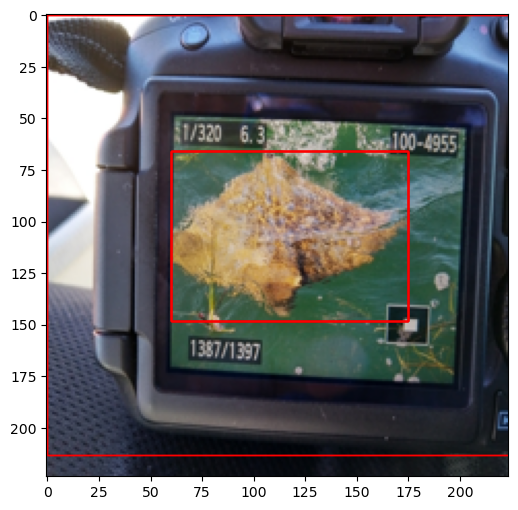

In [26]:
bname = "resnet"

# dataloader initialization
hparams = {
    "mode": None, "Ntrials": None, "popSize": 16,
    "kernel_size": None, "enableSR": False,
    "enableAugm": True,
}

dino_hparams = {
        "prompt": "animal . reptile . object",
        "text_thr": 0.20,
        "box_thr": 0.20,
        "confidence": 1,
}

# load image from S3bucket
dataloader = get_dataloader(1, "imagenet-a", 1, None)
dl = iter(dataloader)

# load image
#img = ttf.to_tensor(Image.open("frog.jpg").convert("RGB").resize((224,224)))
#label = "frog"

# loading classifier backbone and sr model
model = backbone_loading(bname)
srmodel = get_sr_model()

# loading DINO text and box processor and model
dinomodel_spec = "IDEA-Research/grounding-dino-tiny"
processor = AutoProcessor.from_pretrained(dinomodel_spec)
dinomodel = GroundingDinoForObjectDetection.from_pretrained(dinomodel_spec).to(DEVICE)

# load model params
augmenter = get_augmenter()
loss_function = EntropyLoss()
optimizer = get_optimizer(bname, model)


for i in range(dl.__len__()):
    img, label = dl.__next__()
    
    # run for Imagenet-A
    evotta = EvoTTA(img,
                    label,
                    bname,
                    model,
                    srmodel,
                    dinomodel,
                    processor,
                    hparams,
                    dino_hparams,
                    augmenter,
                    loss_function,
                    optimizer,
                    imgsize=(224,224), sr_ratio=0.33, n_classes=1000)

    batch = evotta.zeroshot_region_proposal(display=True)
    err, _, _ = evotta.single_test_time_adaptation(trainIter=1, proposal="default", verbose=True)
    break

---

## Results

Considering the amount of time to be required while performing a single inference run over the whole test set, present attempts were made by fixing the batch size at 16 candidate region proposals while performing the one-iteration training and inference phase. Past attempts assessed the effect of this parameter by increasing the amount of candidate cropped test image portions to 32 (not presented) yielding no significant improvement.

###  Baseline Inference
Estimating the baseline performance on Imagenet-A withouth performing TTA on both backbones (`resnet` and `rvt`).

In [48]:
def baseline_evaluation(backbonename, img_root="imagenet-a", batch_size=128):
    print(f"Now eval: {backbonename}")
    corr_pred, n_sample = 0.0, 0.0
    dataloader = get_dataloader(batch_size, img_root, workers=4, transform=None)
    model = backbone_loading(backbonename)
    model.eval()
    with torch.no_grad():
        for i, (batch, true_labels) in tqdm(enumerate(dataloader)):
            batch = batch.to(DEVICE)
            outputs = model(batch)
            probs = torch.softmax(outputs, -1)
            preds = torch.argmax(probs, -1)
            results = torch.tensor([true_labels[i] == LABELS[pred.item()] for i,pred in enumerate(preds)]).sum().item()
            n_sample += batch.shape[0]
            corr_pred += results
    errorRate = 1 - (corr_pred/n_sample)
    return errorRate

In [49]:
resnet_baseline_err = baseline_evaluation("resnet")

Now eval: resnet
Loading backbone (resnet): Done.


59it [04:13,  4.30s/it]


In [50]:
rvt_baseline_err = baseline_evaluation("rvt")

Now eval: rvt
Loading backbone (rvt): Done.


59it [04:14,  4.32s/it]


Showing baseline inference performance without TTA:


In [27]:
baseline_df = pd.read_csv("baseline_eval.csv")
baseline_df

Unnamed: 0 backbone     error  accuracy
0           0   resnet  0.991733  0.008267
1           1      rvt  0.947200  0.052800

### Baseline Inference with TTA
Now performing inference via 1-epoch Test Time adaptation withouth any of the current region proposal method.

The only difference with respect to the original MEMO implementation is, the usage of AutoAugment. 

Results will be stored in `finaleval_results_tta.csv`.

In [65]:
# performing inference considering a given combination of "evo" and "dino" hparams

hparams = {
    "mode": None,
    "Ntrials": None,
    "popSize": 16,
    "kernel_size": None,
    "enableSR": False,
    "enableAugm": True,
}

dino_hparams = {
    "prompt": None,
    "text_thr": None,
    "box_thr": None,
    "confidence": None,
}

# loading classifier backbone and sr model
for backbonename in ["resnet", "rvt"]:
    model = backbone_loading(backbonename)
    srmodel = get_sr_model()
    
    # loading DINO text and box processor and model
    dinomodel_spec = "IDEA-Research/grounding-dino-tiny"
    
    # load model params
    augmenter = get_augmenter()
    loss_function = EntropyLoss()
    optimizer = get_optimizer(backbonename, model)
    
    # dataloader initialization
    dataloader = get_dataloader(1, "imagenet-a", 1, None)
    
    evalEvoTTA = EvalEvoTTA(
        backbonename, model, srmodel, dinomodel_spec,
        augmenter, loss_function, optimizer, dataloader,
        nclass2label=LABELS,
        label2label=COMMON,
        outfile="finaleval_results_tta.csv"
    )
    
    evalEvoTTA.run_single_hset(hparams, dino_hparams, proposal="default")

Loading backbone (rvt): Done.
Loading optimizer for backbone (rvt), Done!
Now on: {'mode': None, 'Ntrials': None, 'popSize': 16, 'kernel_size': None, 'enableSR': False, 'enableAugm': True}


/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 7500/7500 [36:02<00:00,  3.47it/s]


Loading backbone (rvt): Done.
Loading optimizer for backbone (rvt), Done!
Now on: {'mode': None, 'Ntrials': None, 'popSize': 16, 'kernel_size': None, 'enableSR': False, 'enableAugm': True}


/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
  4%|▍         | 283/7500 [01:22<35:00,  3.44it/s]


KeyboardInterrupt: 

In [66]:
baseline_tta_eval = pd.read_csv("finaleval_results_tta.csv")
baseline_tta_eval

backbone proposal  popSize  Ntrials  mode  kernel_size  \
0   resnet  default       16      NaN   NaN          NaN   
1      rvt  default       16      NaN   NaN          NaN   

                                              prompt  text_thr  box_thr  \
0  animal . mammal . reptile . bird . fish . bug ...       0.2      0.2   
1  animal . mammal . reptile . bird . fish . bug ...       0.2      0.2   

   enableSR  enableAugm  trainIter  errorRate       time  
0     False        True          1   0.986133  1464.5735  
1     False        True          1   0.906133  2164.4454

### Evolutionary RP results
The present chunk to set evolutionary hyperparameters (`hparams`) and to perform the test set inference evaluation over backbones.<br/> 
Although not shown, the difference in performance while allowing to rescale small size cropped region via SR is negligible and therefore in all present attempts the `enableSR` condition had been always set to `False`. Furthermore, given that the current implementation does not allow to tackle intra-image optimization in parallel and although, by also excluding SR upscaling, the resulting processing time was still found to be expensive, we focused over the following combinations:

- _Ngenerations:_ `5`, _population_size:_ `16`, _Evolutionary modality:_ `model`.
- _Ngenerations:_ `5`, _population_size:_ `16`, _Evolutionary modality:_ `emap`, _kernel_size:_ `{3, 11}`.
- _Ngenerations:_ `5`, _population_size:_ `16`, _Evolutionary modality:_ `freqmap`, _kernel_size:_ `{3, 11}`.

for which {`model`, `emap`, `freqmap`} represent the Model based, Entropy pooling feature map from grayscaled image, Entropy pooling feature map from high-pass freq filtered image approaches respectively. In order to foster variability between candidate region proposal the amount of generations had been set to 5 to allow for a _guided_ search and to avoid solutions to be overly-focused on a limited image area, _de-facto_ without yielding the search procedure to effectively converge over global/local minimum/a. (!!!)

Results will be saved in `finaleval_results_evo.csv`.

In [29]:
hparams = {
    "mode": "emap",
    "Ntrials": 5,
    "popSize": 16,
    "kernel_size": 11,
    "enableSR": False,
    "enableAugm": True,
}

dino_hparams = {
    "prompt": None,
    "text_thr": None,
    "box_thr": None,
    "confidence": None,
}

# loading classifier backbone and sr model
for backbonename in ["resnet", "rvt"]:
    
    model = backbone_loading(backbonename)
    srmodel = get_sr_model()
    
    # loading DINO text and box processor and model
    dinomodel_spec = "IDEA-Research/grounding-dino-tiny"
    
    # load model params
    augmenter = get_augmenter()
    loss_function = EntropyLoss()
    optimizer = get_optimizer(backbonename, model)
    
    # dataloader initialization
    dataloader = get_dataloader(1, "imagenet-a", 1, None)
    
    evalEvoTTA = EvalEvoTTA(
        backbonename, model, srmodel, dinomodel_spec,
        augmenter, loss_function, optimizer, dataloader,
        nclass2label=LABELS,
        label2label=COMMON,
        outfile="finaleval_results_evo.csv"
    )
    
    evalEvoTTA.run_single_hset(hparams, dino_hparams, proposal="evo")

Loading backbone (resnet): Done.
Loading optimizer for backbone (resnet), Done!
Now on: {'mode': 'emap', 'Ntrials': 5, 'popSize': 16, 'kernel_size': 11, 'enableSR': False, 'enableAugm': True}


/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
  0%|          | 17/7500 [00:04<32:41,  3.81it/s]/opt/conda/lib/python3.10/site-packages/scipy/stats/_entropy.py:133: RuntimeWarning: invalid value encountered in divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)
100%|██████████| 7500/7500 [42:18<00:00,  2.95it/s]  


Loading backbone (rvt): Done.
Loading optimizer for backbone (rvt), Done!
Now on: {'mode': 'emap', 'Ntrials': 5, 'popSize': 16, 'kernel_size': 11, 'enableSR': False, 'enableAugm': True}


/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
  0%|          | 17/7500 [00:06<48:04,  2.59it/s]/opt/conda/lib/python3.10/site-packages/scipy/stats/_entropy.py:133: RuntimeWarning: invalid value encountered in divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)
100%|██████████| 7500/7500 [56:45<00:00,  2.20it/s]  


### Zero-shot object detection RP results

In this section, dino parameters will be initialise to guide the box detection according to a given:
- `prompt`: a string of targets to semantically guide the detection which had been set by `"animal . mammal . reptile . bird . fish . bug . object . tool"` in order to vaguely resemble test set classes.
- `text_thr`: minimum amount of confidence to retain a solution according to the provided prompt (set to `0.2`).
- `box_thr`: minimum amount of confidence to retein a bounding box (set to `0.2`).
- `confidence`: percentage of the top final region proposal outcome sorted by box confidence to retain before sampling according to dino box confidence (set to `1`). This parameter had not been tuned allowing to sample directly from the whole amount of DINO predictions: further experiments are needed in order evaluate the final inference by selecting the DINO _topN_ candidates.

In [29]:
hparams = {
    "mode": None,
    "Ntrials": None,
    "popSize": 16,
    "kernel_size": None,
    "enableSR": False,
    "enableAugm": True,
}

dino_hparams = {
    "prompt": "animal . mammal . reptile . bird . fish . bug . object . tool",
    "text_thr": 0.20,
    "box_thr": 0.20,
    "confidence": 1,
}

# loading classifier backbone and sr model
for backbonename in ["resnet", "rvt"]:
    
    model = backbone_loading(backbonename)
    srmodel = get_sr_model()
    
    # loading DINO text and box processor and model
    dinomodel_spec = "IDEA-Research/grounding-dino-tiny"
    
    # load model params
    augmenter = get_augmenter()
    loss_function = EntropyLoss()
    optimizer = get_optimizer(backbonename, model)
    
    # dataloader initialization
    dataloader = get_dataloader(1, "imagenet-a", 1, None)
    
    evalEvoTTA = EvalEvoTTA(
        backbonename, model, srmodel, dinomodel_spec,
        augmenter, loss_function, optimizer, dataloader,
        nclass2label=LABELS,
        label2label=COMMON,
        outfile="finaleval_results.csv"
    )
    
    evalEvoTTA.run_single_hset(hparams, dino_hparams, proposal="dino")

Loading backbone (rvt): Done.
Now on: {'mode': None, 'Ntrials': None, 'popSize': 16, 'kernel_size': None, 'enableSR': False, 'enableAugm': True}


/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
  0%|          | 0/7500 [00:00<?, ?it/s]/tmp/ipykernel_167/2546076919.py:484: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sorted_boxes = torch.cat([torch.tensor(box).unsqueeze(0) for _, box in tmp], 0)
100%|██████████| 7500/7500 [1:38:08<00:00,  1.27it/s]  


0.8578666666666667

In [30]:
# performing inference considering a given combination of "evo" and "dino" hparams

hparams = {
    "mode": None,
    "Ntrials": None,
    "popSize": 32,
    "kernel_size": None,
    "enableSR": False,
    "enableAugm": True,
}

dino_hparams = {
    "prompt": "animal . mammal . reptile . bird . fish . bug . object . tool",
    "text_thr": 0.20,
    "box_thr": 0.20,
    "confidence": 1,
}

# loading classifier backbone and sr model
for backbonename in ["resnet", "rvt"]:
    
    model = backbone_loading(backbonename)
    srmodel = get_sr_model()
    
    # loading DINO text and box processor and model
    dinomodel_spec = "IDEA-Research/grounding-dino-tiny"
    
    # load model params
    augmenter = get_augmenter()
    loss_function = EntropyLoss()
    optimizer = get_optimizer(backbonename, model)
    
    # dataloader initialization
    dataloader = get_dataloader(1, "imagenet-a", 1, None)
    
    evalEvoTTA = EvalEvoTTA(
        backbonename, model, srmodel, dinomodel_spec,
        augmenter, loss_function, optimizer, dataloader,
        nclass2label=LABELS,
        label2label=COMMON,
        outfile="finaleval_results.csv"
    )
    
    evalEvoTTA.run_single_hset(hparams, dino_hparams, proposal="dino")

Loading backbone (rvt): Done.
Loading optimizer for backbone (rvt), Done!
Now on: {'mode': None, 'Ntrials': None, 'popSize': 32, 'kernel_size': None, 'enableSR': False, 'enableAugm': True}


/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
  0%|          | 0/7500 [00:00<?, ?it/s]/tmp/ipykernel_149/2546076919.py:484: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sorted_boxes = torch.cat([torch.tensor(box).unsqueeze(0) for _, box in tmp], 0)
100%|██████████| 7500/7500 [2:16:28<00:00,  1.09s/it]  


0.8548

### Performance comparison
The present section to merge the resulting outcomes.

**Replication studies.** Although some minor fluctuation mostly due to stochasticity, `resnet`-based performance at baseline and MEMO TTA evaluation proved to be similar as those presented by (Zang et al., 2022) (100, 99.1 versus 99.1, 98.6). One may explain this small difference by means of error rate gain thanks to AutoAugmentation.<br/>
Despite several attempts to match the same reference requirements and despite having not adopted the same pool of augmentation functions as in baseline and TTA performance by adopting `rvt*-small` backbone failed to replicate the error rate as in the reference MEMO paper showing biased performance (73.9 versus 94.7 for the baseline evaluation 69.8 versus 90.6 for the MEMO TTA). However, our implementation proved that the performance gain was found to be similiar (-4.1) to that shown in the reference.

**Summary**
- `emap`: none of the previously defined runs by tuning the kernel size proved to improve MEMO
| backbone | baseline | MEMO TTA | Evo<br/> model-based |Evo<br/> emap-based<br/>kernel size = 3 | Evo<br/> emap-based<br/>kernel size = 11 |  Evo<br/> freqmap-based<br/>kernel size = 3 | Evo<br/> freqmap-based<br/>kernel size = 11 | gDINO<br/>box_thr=0.2, text_thr=0.2,<br/> confidence=1 |
|----------|----------|----------|---------|--------|-------|--------|---------|--------|
| resnet   | 99.1     | 98.6     | 98.8 (+0.2)    | 99.2 (+0.6) |  99.2 (+0.6)  |     |     | **98.4** (-0.2)   |
| rvt*-small | 94.7   | 90.6     | 92.3 (+1.7)    |92.4 (+1.8)  |  92.9 (+2.3)      |     |     | **85.7** (-4.9)  |



Discuss the prompt tuning in DINO (one can actually adapt over a semantically related amount of classes if the test set is known in advance)

---

## Discussion


## Conclusion


## References

Bai, J., Yuan, L., Xia, S. T., Yan, S., Li, Z., & Liu, W. (2022, October). Improving vision transformers by revisiting high-frequency components. In European Conference on Computer Vision (pp. 1-18). Cham: Springer Nature Switzerland.

Bartz‐Beielstein, T., Branke, J., Mehnen, J., & Mersmann, O. (2014). Evolutionary algorithms. Wiley Interdisciplinary Reviews: Data Mining and Knowledge Discovery, 4(3), 178-195.

Cubuk, E. D., Zoph, B., Mane, D., Vasudevan, V., & Le, Q. V. (1805). Autoaugment: Learning augmentation policies from data. arXiv 2018. arXiv preprint arXiv:1805.09501, 2.

Liang, J., Cao, J., Sun, G., Zhang, K., Van Gool, L., & Timofte, R. (2021). Swinir: Image restoration using swin transformer. In Proceedings of the IEEE/CVF international conference on computer vision (pp. 1833-1844).

Liu, S., Zeng, Z., Ren, T., Li, F., Zhang, H., Yang, J., & Zhang, L. (2023). Grounding dino: Marrying dino with grounded pre-training for open-set object detection. arXiv preprint arXiv:2303.05499.

Nomura, M., & Shibata, M. (2024). Cmaes: A simple yet practical Python library for CMA-ES. arXiv preprint arXiv:2402.01373.

Zhang, M., Levine, S., & Finn, C. (2022). Memo: Test time robustness via adaptation and augmentation. Advances in neural information processing systems, 35, 38629-38642.

Fix the following cells!!!

In [ ]:
# set hyperparams
backbonename    = ("resnet") # ["resnet", "vit", "rvt"]
modes           = ("emap", "freqmap") #("model", "emap", "freqmap")
Ntrials         = (5,)
popSizes        = (16,) # or [8, 16]
kernel_sizes    = (3, 5, 11)
sr_conditions   = (False,)
augm_conditions = (True,)

# draw combinations
combinations = list(itertools.product(modes, Ntrials, popSizes, kernel_sizes,
                                      sr_conditions, augm_conditions))

In [ ]:
# model initialization
for bname in ["resnet", "vit", "rvt"]:

    # dataloader initialization
    img_root = "imagenet-a"
    dataloader = get_dataloader(1, img_root, 1, None)

    model = backbone_loading(bname)
    srmodel = get_sr_model()
    augmenter = get_augmenter()
    loss_function = EntropyLoss()
    optimizer = get_optimizer(bname, model)
    #optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))

    # run for Imagenet-A
    finaleval = EvalEvoTTA(bname, model, srmodel, augmenter, loss_function,
                           optimizer, combinations, dataloader,
                           nclass2label=LABELS, label2label=COMMON,
                           outfile="finaleval_results.csv")

    errorrate = finaleval.run_single_hset(
        #combination = ('emap', 5, 8, 3, False, True),
        combination = ('model', 5, 16, None, False, True),
        evoProposal=True,
        trainIter = 1,
        verbose = False)

In [ ]:
# models initialization
for bname in ["resnet", "rvt"]:

    # dataloader initialization
    img_root = "imagenet-a"
    dataloader = get_dataloader(1, img_root, 1, None)

    model = backbone_loading(bname)
    srmodel = get_sr_model()
    augmenter = get_augmenter()
    loss_function = EntropyLoss()
    optimizer = get_optimizer(bname, model)
    #optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))

    # run for Imagenet-A
    finaleval = EvalEvoTTA(bname, model, srmodel, augmenter, loss_function,
                           optimizer, combinations, dataloader,
                           nclass2label=LABELS, label2label=COMMON,
                           outfile="finaleval_results.csv")

    errorrate = finaleval.run_single_hset(
        #combination = ('emap', 5, 8, 3, False, True),
        combination = ("emap", 5, 16, 7, False, True),
        evoProposal=True,
        trainIter = 1,
        verbose = False)

In [ ]:
# models initialization
for bname in ["resnet", "rvt"]:

    # dataloader initialization
    img_root = "imagenet-a"
    dataloader = get_dataloader(1, img_root, 1, None)

    model = backbone_loading(bname)
    srmodel = get_sr_model()
    augmenter = get_augmenter()
    loss_function = EntropyLoss()
    optimizer = get_optimizer(bname, model)
    #optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))

    # run for Imagenet-A
    finaleval = EvalEvoTTA(bname, model, srmodel, augmenter, loss_function,
                           optimizer, combinations, dataloader,
                           nclass2label=LABELS, label2label=COMMON,
                           outfile="finaleval_results.csv")

    errorrate = finaleval.run_single_hset(
        #combination = ('emap', 5, 8, 3, False, True),
        combination = ("freqmap", 5, 16, 7, False, True),
        evoProposal=True,
        trainIter = 1,
        verbose = False)

### Testing and displaying + loss difference

In [ ]:
filename = "hawk2.jpg"
img = ttf.to_tensor(Image.open(filename).convert("RGB").resize((224,224)))
true_label = "eagle" # sort of

bname = "vit"
model = backbone_loading(bname)
srmodel = get_sr_model()
augmenter = get_augmenter()
loss_function = EntropyLoss()
#optimizer = get_optimizer(bname, model)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

hparams = {
    "mode":"freqmap",
    "popSize":16,
    "Ntrials":80,
    "kernel_size":3,
    "enableSR":False,
    "enableAugm":True
}
predss = []

evoTTA = EvoTTA(img, true_label, backbonename, model, srmodel, hparams, augmenter, loss_function, optimizer )
batch, cand_bb, solutions      = evoTTA.evolve(verbose=False, display=False)
batch, cum_prob, cum_loss      = evoTTA.single_test_time_adaptation(trainIter=1, evoProposal=False, verbose=True)
pred_label, pred_class_n, conf = evoTTA.get_pred_label(cum_prob, LABELS, "avg")
pred_label = COMMON[pred_label]
print(f"True Label: {true_label} \nPred Label: {pred_label}")

### Evaluation
In this section we visualize the performance.

##### #? Reminder: nell'assignment viene indicato:
"Organize the scores obtained in tables, including charts depicting learning curves,
confusion matrices, and other useful visual representations"


1. Learning curves, considerato che le learning curves sono di solo due punti nel tempo  (la zero shot + la prima inferenza dopo un training, corretto?) è necessario
    - immagazzinare da qualche parte la accuracy di questi due punti (per ora stiamo immagazzinando solo il risultato della prima inferenza)
    - visualizzare le accuracy tramite un istogramma con due colonne
2. Confusion matrices

    - Immagino che possiamo usare sklearn's Confusion Matrix per plottare i risultati. C'è da dire che abbiamo tante classi, quindi non so se sia utile plottare tutte lungo una matrice...
    - Penso che ci sia un forte bisogno di immagazzinare le predizioni di ogni modello. Non le trovo da nessuna parte qui, perché vedo che non vengono immagazzinate... faccio un esempio qui sotto di come fare per avere risultati consultabili **facilmente**, con un dataframe multi-index (come dizionario di dizionari).

In [ ]:
import random
from datetime import datetime

In [ ]:
## Un modello f con certi parametri inizia il suo processo
## ...
## finalmente otteniamo la lista "pred_label" per il modello f


if not os.path.isfile('label_storage.csv'):
    label_storage = pd.DataFrame({'Model parameters': [], 'Labels': [], 'Date':[]})
    label_storage.to_csv('label_storage.csv', sep=';')
    print('Created label_storage.')
else:
    label_storage = pd.read_csv('label_storage.csv', sep=',')

labels = [random.randrange(100) for i in range(1, 5)] #facciamo finta che queste siano le classi come risultato del modello

## recuperiamo i parametri per identificare il modello e finalmente salviamo in un file  (devo ridefinirli perché non riesco a runnare le celle sopra causa DINO sotto costruzione

hparams = {
    "mode":"freqmap",
    "popSize":16,
    "Ntrials":80,
    "kernel_size":3,
    "enableSR":False,
    "enableAugm":True
}
date = datetime.now().strftime('%D,%H:%M')

row = pd.DataFrame({'Model parameters':[pd.DataFrame(hparams, index=[0])],
                    'Labels':[pd.DataFrame(labels)],
                    'Date':[date]}, index=[0])


if label_storage.shape[0]:    #se il dataframe è vuoto non controlliamo che ci siano duplicati

    if label_storage.iloc[-1,:].Date != date:   #controllo di duplicati in base al giorno, ore:minuti
        label_storage = pd.concat([label_storage, row], ignore_index=True)

else:
    label_storage = pd.concat([label_storage, row], ignore_index=True)
label_storage.to_csv('label_storage.csv', sep=';')
print('Model labels stored')
label_storage

Model labels stored


;Model parameters;Labels;Date  \
0                           NaN   

                                    Model parameters  \
0        mode  popSize  Ntrials  kernel_size  ena...   

                          Labels            Date  
0      0
0  39
1  74
2   2
3  50  06/19/24,13:20

In [ ]:
label_storage.iloc[0,:]['Model parameters']
# oppure
#label_storage.iloc[0,:]['Labels']
# per accedere ai dataframe interni alle celle.

mode  popSize  Ntrials  kernel_size  enableSR  enableAugm
0  freqmap       16       80            3     False        True

In [ ]:
df = pd.read_csv('finaleval_results.csv')
df.sort_values(by=['backbone', 'mode', 'popSize'])

backbone     mode  Ntrials  popSize  kernel_size  enableSR  enableAugm  \
8   resnet     emap      5.0        4          5.0     False        True   
4   resnet     emap      5.0       16          3.0     False        True   
6   resnet  freqmap      5.0       16          3.0     False        True   
2   resnet    model      5.0       16          NaN     False        True   
0   resnet      NaN      NaN       16          NaN     False        True   
5      rvt     emap      5.0       16          3.0     False        True   
7      rvt  freqmap      5.0       16          3.0     False        True   
3      rvt    model      5.0       16          NaN     False        True   
1      rvt      NaN      NaN       16          NaN     False        True   

   trainIter  errorRate       time  
8          1   0.992133  1419.0458  
4          1   0.991867  2769.6159  
6          1   0.990533  1974.8416  
2          1   0.988533  4076.8551  
0          1   0.985733  1460.1049  
5          1   0.924933  3543.3150  
7          1   0.934267  2787.1137  
3          1   0.920000  5753.6733  
1          1   0.906800  2184.2051

In [ ]:
cm = confusion_matrix(y_test, predictions)
ConfusionMatrixDisplay(cm).plot()

<Axes: xlabel='errorRate', ylabel='time'>

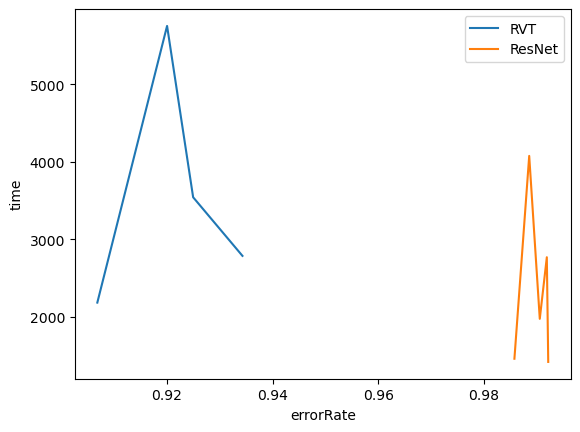

In [ ]:
sns.lineplot(data=df[df.backbone == 'rvt'], x='errorRate', y='time', label='RVT')
sns.lineplot(data=df[df.backbone == 'resnet'], x='errorRate', y='time', label='ResNet')

Displaying where the cropping regions coordinates had been converged according to a given `generation`.


Some notes:
apparently the mean initialisation seems not to influence the final convergence given sufficient instances to explore the space for a reasonable amount of generations. Some parameters are still needed to be tuned. The entropy minimum reached by the search algorithm is not corresponding to the perfectly cropped image subject. We may hope to rely on few optimisation evolutionary runs in order to get some original test image cropped areas to be used as prediction.
We can also try to classify each test image according to the resulting candidates over $N$ generations
